# Prosper Loan data exploration
## by Andy Watson

## Preliminary Wrangling

Little wrangling is needed.
Udacity provided us with a clean csv file from Prosper Financials.
But we will change the ListingCreationDate column from object to datetime format.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
loan = pd.read_csv('prosperLoanData.csv')

Below I make a few adjustments to the loan data frame.

1. Change the ListingCreationDate format to datetime.

2. Create a data frame for loans created up through 2008. I will limit my investigations through 2008 because all those loans terms should've been completed by 2014 (the longest term is 5 years and 2013-5=2008).

3. Create "Successful" (rename "Completed") and "Unsuccessful" (including both "Chargedoff" and "Defaulted") columns.

4. Create an ROI (return on investment) column.

5. Turn the ordinal variables (that I will be investigating) into categorical variables.

6. Create lists of each type of variable for the variables I'll be investigating.

ROI = (LP_CustomerPyaments - LoanOrignalAmount - LP_ServiceFees - LP_CollectionFees + LP_NonPrincipalRecoverypayments)/LoanOriginalAmount

In [3]:
loan['ListingCreationDate'] = pd.to_datetime(loan['ListingCreationDate'])

In [4]:
loans_to_2008 = (loan[loan['ListingCreationDate'].dt.year <= 2008]).copy()

In [5]:
# creating successful and unsuccessful columns
# create a dictionary so you can map the values onto the new category names

dict_map = dict(zip(['Completed', 'Chargedoff', 'Defaulted', 'Cancelled'], ['Successful', 'Unsuccessful', 'Unsuccessful', 'Cancelled']))
dict_map
loans_to_2008['NewLoanStatus'] = loans_to_2008['LoanStatus'].map(dict_map)

In [6]:
loans_to_2008['ROI'] = (loans_to_2008['LP_CustomerPayments'] - loans_to_2008['LoanOriginalAmount'] - loans_to_2008['LP_ServiceFees'] - loans_to_2008['LP_CollectionFees'] + loans_to_2008['LP_NonPrincipalRecoverypayments'])/loans_to_2008['LoanOriginalAmount'] 

In [7]:
# as an exercise, I'll turn these ordinal variables into categories computationally.

# convert CreditGrade and IncomeRange into ordered categorical types
ordinal_var_dict = {'CreditGrade': ['AA', 'A', 'B', 'C', 'D', 'E', 'HR','NC'],
                    'IncomeRange': ['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+','Not employed', 'Not displayed'],
                   'CreditScoreRangeUpper': ['19.0', '379.0', '439.0', '459.0', '479.0', '499.0', '519.0', '539.0', '559.0', '579.0', '599.0', '619.0', '639.0','659.0', '679.0', '699.0', '719.0', '739.0', '759.0', '779.0', '799.0', '819.0', '839.0', '859.0', '879.0', '899.0', 'nan']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    loans_to_2008[var] = loans_to_2008[var].astype(ordered_var)

In [8]:
numeric_vars = ['AmountDelinquent']
percent_vars = ['DebtToIncomeRatio']
ordinal_vars = ['CreditGrade', 'IncomeRange']
nominal_vars = ['BorrowerState', 'Occupation']
binary_vars = ['IsBorrowerHomeowner', 'EmploymentStatus']

### What is the structure of your dataset?

The file contains data on 113,937 loans (rows) with 81 variables (columns). 

Variables include loan amount, interest rate, information about borrower's financial history, and current loan status. 

The data was collected from 2005 through 2014.

### What is/are the main feature(s) of interest in your dataset?

My goal here is to find variables that can accurately predict a loan's outcome. 

In order to make the project manageable, I will restrict my focus to information about the borrower.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

#### Quantitative Variables:

I expect the borrower's credit rating score to accurately predict loan outcomes. The credit rating is created by financial institutions to assess a borrower's credit risk based on current and historical financial data about the borrower. 

Borrower income range and  debt to income ratio should also correlate strongly with loan outcomes.

#### Categorical Variables:

I will also explore two categorical variables: borrower's state, and borrower occupation.

#### Loan outcome data

##### The first primary variable I tried was LoanStatus: the current status of the loan: 

Cancelled,  Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue. The PastDue status will be accompanied by a delinquency bucket.

In order to compare likes to likes and to avoid comparing new loans with older ones (the new ones will of course have a much lower default rate), I will restrict my analysis to loans that originated from 2005 through 2008. The loans originating in this time period were all either 12 or 36 month loans. Therefore, according to the original loan terms, they should've been completed long before 2014, when they stopped updating the data. For that date range, there were 29056 loans.

In the course of my investigations, my thoughts about how best to understand a loan's success varied. 

First I combined the Chargedoff and Defaulted categories into one category 'Unsuccessful' and the Completed category I renamed 'Successful' (the only other category applicable to my time range was Cancelled -- but I wasn't sure if a cancelled loan should count as a success or a failure, and there were only 5 of them anyway, so I ignored that category).

Soon I doubted the sufficiency of this initial 'Unsuccessful' / 'Successful' metric. It didn't account for how much of a loan was paid off before it was cancelled. 

##### So I created another primary variable:
A new column called 'ROI', where I calculated the return on investment using this formula:

(loans_to_2008['LP_CustomerPayments'] - loans_to_2008['LoanOriginalAmount'] - loans_to_2008['LP_ServiceFees'] - loans_to_2008['LP_CollectionFees'] + loans_to_2008['LP_NonPrincipalRecoverypayments'])/loans_to_2008['LoanOriginalAmount'] 

## Preliminary Investigation of Data 

In [4]:
loan.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [5]:
loan.info

<bound method DataFrame.info of                      ListingKey  ListingNumber     ListingCreationDate  \
0       1021339766868145413AB3B         193129 2007-08-26 19:09:29.263   
1       10273602499503308B223C1        1209647 2014-02-27 08:28:07.900   
2       0EE9337825851032864889A          81716 2007-01-05 15:00:47.090   
3       0EF5356002482715299901A         658116 2012-10-22 11:02:35.010   
4       0F023589499656230C5E3E2         909464 2013-09-14 18:38:39.097   
...                         ...            ...                     ...   
113932  E6D9357655724827169606C         753087 2013-04-14 05:55:02.663   
113933  E6DB353036033497292EE43         537216 2011-11-03 20:42:55.333   
113934  E6E13596170052029692BB1        1069178 2013-12-13 05:49:12.703   
113935  E6EB3531504622671970D9E         539056 2011-11-14 13:18:26.597   
113936  E6ED3600409833199F711B7        1140093 2014-01-15 09:27:37.657   

       CreditGrade  Term              LoanStatus           ClosedDate  \
0     

In [9]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

In [32]:
# show right side of dataframe
loan_right = loan.iloc[0:1000, 63:76].copy()
loan_right.head()

,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments
0,9425,2007-09-12 00:00:00,Q3 2007,1F3E3376408759268057EDA,330.43,11396.14,9425.00,1971.14,-133.18,0.0,0.0,0.0,0.0
1,10000,2014-03-03 00:00:00,Q1 2014,1D13370546739025387B2F4,318.93,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
2,3001,2007-01-17 00:00:00,Q1 2007,5F7033715035555618FA612,123.32,4186.63,3001.00,1185.63,-24.20,0.0,0.0,0.0,0.0
3,10000,2012-11-01 00:00:00,Q4 2012,9ADE356069835475068C6D2,321.45,5143.20,4091.09,1052.11,-108.01,0.0,0.0,0.0,0.0
4,15000,2013-09-20 00:00:00,Q3 2013,36CE356043264555721F06C,563.97,2819.85,1563.22,1256.63,-60.27,0.0,0.0,0.0,0.0


In [31]:
# show instances where the debth was charged off
loan_right[loan_right['LP_NonPrincipalRecoverypayments'] > 0].head()

,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments
17,10000,2006-08-22 00:00:00,Q3 2006,893E3365582060699EBBADA,334.54,5325.33,3987.33,1338.00,-54.61,0.00,6012.65,6012.67,268.96
103,15000,2012-04-19 00:00:00,Q2 2012,F11E34621201188152DD3DA,579.63,3968.89,1119.05,2849.84,-49.41,-813.65,13880.95,13880.95,1600.00
138,3000,2012-03-21 00:00:00,Q1 2012,87C83528199783859742DC3,127.34,127.34,23.82,103.52,-5.90,0.00,2976.18,0.00,764.27
185,6000,2010-08-09 00:00:00,Q3 2010,367B348955246532073DD98,234.30,3748.80,2155.59,1593.21,-67.39,0.00,3844.41,3844.41,685.00
251,17500,2006-11-13 00:00:00,Q4 2006,AE023364899153293DA6164,614.64,17565.17,13663.22,3901.95,-106.75,-1106.34,3842.60,2221.08,889.34


In [6]:
loan.value_counts()

Series([], dtype: int64)

In [7]:
loan.describe()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
count,1.139370e+05,113937.000000,113912.000000,113937.000000,113937.000000,84853.000000,84853.000000,84853.000000,84853.000000,84853.000000,...,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000
mean,6.278857e+05,40.830248,0.218828,0.192764,0.182701,0.168661,0.080306,0.096068,4.072243,5.950067,...,-54.725641,-14.242698,700.446342,681.420499,25.142686,0.998584,0.048027,0.023460,16.550751,80.475228
std,3.280762e+05,10.436212,0.080364,0.074818,0.074516,0.068467,0.046764,0.030403,1.673227,2.376501,...,60.675425,109.232758,2388.513831,2357.167068,275.657937,0.017919,0.332353,0.232412,294.545422,103.239020
min,4.000000e+00,12.000000,0.006530,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,1.000000,...,-664.870000,-9274.750000,-94.200000,-954.550000,0.000000,0.700000,0.000000,0.000000,0.000000,1.000000
25%,4.009190e+05,36.000000,0.156290,0.134000,0.124200,0.115670,0.042400,0.074080,3.000000,4.000000,...,-73.180000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000
50%,6.005540e+05,36.000000,0.209760,0.184000,0.173000,0.161500,0.072400,0.091700,4.000000,6.000000,...,-34.440000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,44.000000
75%,8.926340e+05,36.000000,0.283810,0.250000,0.240000,0.224300,0.112000,0.116600,5.000000,8.000000,...,-13.920000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,115.000000
max,1.255725e+06,60.000000,0.512290,0.497500,0.492500,0.319900,0.366000,0.283700,7.000000,11.000000,...,32.060000,0.000000,25000.000000,25000.000000,21117.900000,1.012500,39.000000,33.000000,25000.000000,1189.000000


In [8]:
loan['LoanStatus']

0                      Completed
1                        Current
2                      Completed
3                        Current
4                        Current
                   ...          
113932                   Current
113933    FinalPaymentInProgress
113934                   Current
113935                 Completed
113936                   Current
Name: LoanStatus, Length: 113937, dtype: object

In [9]:
loan.groupby('LoanStatus').describe()

ListingNumber                                          \
                               count           mean            std       min   
LoanStatus                                                                     
Cancelled                        5.0   87767.200000  180178.635718     908.0   
Chargedoff                   11992.0  364864.921364  197898.726241     156.0   
Completed                    38074.0  388419.870121  213516.255126       4.0   
Current                      56576.0  876833.378199  210349.150769  464139.0   
Defaulted                     5018.0  232427.769829  189488.459787      99.0   
FinalPaymentInProgress         205.0  747528.004878  202541.470503  489610.0   
Past Due (1-15 days)           806.0  710421.168734  163273.523789  471640.0   
Past Due (16-30 days)          265.0  703710.335849  150930.601944  492772.0   
Past Due (31-60 days)          363.0  712121.658402  154116.557782  491495.0   
Past Due (61-90 days)          313.0  690544.562300  136034.292526  488826.0   
Past Due (91-120 days)         304.0  669112.799342  120903.929615  482134.0   
Past Due (>120 days)            16.0  649402.625000  111548.326149  517786.0   

                                                                       Term  \
                              25%       50%         75%        max    count   
LoanStatus                                                                    
Cancelled                 7646.00    8912.0    11364.00   410006.0      5.0   
Chargedoff              188513.75  369917.0   534035.50   932346.0  11992.0   
Completed               221154.50  425475.5   529267.50  1204824.0  38074.0   
Current                 694592.50  883436.0  1057011.50  1255725.0  56576.0   
Defaulted                69063.75  178389.0   367876.25  1099553.0   5018.0   
FinalPaymentInProgress  569532.00  719603.0   908166.00  1240719.0    205.0   
Past Due (1-15 days)    575699.50  662199.5   830913.00  1184124.0    806.0   
Past Due (16-30 days)   588835.00  668132.0   801508.00  1123445.0    265.0   
Past Due (31-60 days)   583373.00  665787.0   840125.00  1112078.0    363.0   
Past Due (61-90 days)   591478.00  651766.0   788166.00  1069344.0    313.0   
Past Due (91-120 days)  573197.50  640280.0   765599.25  1016433.0    304.0   
Past Due (>120 days)    548950.25  630783.5   766740.50   829185.0     16.0   

                                   ... InvestmentFromFriendsAmount            \
                             mean  ...                         75%       max   
LoanStatus                         ...                                         
Cancelled               36.000000  ...                         0.0      0.00   
Chargedoff              38.029353  ...                         0.0  12500.00   
Completed               36.613962  ...                         0.0  25000.00   
Current                 44.511736  ...                         0.0   3000.00   
Defaulted               36.841770  ...                         0.0   8200.00   
FinalPaymentInProgress  39.278049  ...                         0.0    250.00   
Past Due (1-15 days)    43.354839  ...                         0.0    845.00   
Past Due (16-30 days)   43.698113  ...                         0.0    525.58   
Past Due (31-60 days)   44.066116  ...                         0.0      0.00   
Past Due (61-90 days)   43.974441  ...                         0.0      0.00   
Past Due (91-120 days)  44.605263  ...                         0.0      0.00   
Past Due (>120 days)    46.500000  ...                         0.0      0.00   

                       Investors                                            \
                           count        mean         std  min    25%   50%   
LoanStatus                                                                   
Cancelled                    5.0   24.600000   22.678183  6.0   7.00  23.0   
Chargedoff               11992.0   96.110657  102.788349  1.0  28.00  61.0   
Completed                38074.0  108.223854 

In [24]:
loan.groupby('LoanStatus').mean()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
LoanStatus,,,,,,,,,,,,,,,,,,,,,
Cancelled,87767.200000,36.000000,0.205826,0.184400,0.178400,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,24.600000
Chargedoff,364864.921364,38.029353,0.257752,0.235397,0.224656,0.218423,0.116322,0.123379,2.882871,5.390742,...,-46.863075,-49.842038,4662.518525,4608.299671,136.912133,0.997808,0.085474,0.036191,32.136696,96.110657
Completed,388419.870121,36.613962,0.208781,0.186422,0.176595,0.163086,0.086753,0.102430,3.907648,6.536513,...,-57.650019,-5.104060,0.000000,0.000000,0.000000,0.998702,0.092452,0.051584,36.283888,108.223854
Current,876833.378199,44.511736,0.213740,0.183771,0.173771,0.163595,0.073381,0.090227,4.288426,5.837952,...,-55.021413,-1.852073,0.000000,0.000000,0.000000,0.998664,0.009191,0.002209,0.585536,57.140148
Defaulted,232427.769829,36.841770,0.238925,0.223077,0.212097,0.209420,0.111961,0.123416,3.015920,5.619900,...,-39.681192,-116.638448,4761.624705,4459.202419,243.689113,0.999261,0.075528,0.028298,16.612698,100.659426
FinalPaymentInProgress,747528.004878,39.278049,0.229558,0.196960,0.186960,0.176569,0.083253,0.093316,3.956098,5.751220,...,-68.433366,-4.627024,0.000000,0.000000,0.000000,0.996479,0.009756,0.014634,2.560878,76.751220
Past Due (1-15 days),710421.168734,43.354839,0.263828,0.230797,0.220797,0.208204,0.097967,0.110621,3.373449,5.042184,...,-79.069007,-72.582581,0.000000,0.000000,0.000000,0.997539,0.014888,0.002481,1.166253,66.997519
Past Due (16-30 days),703710.335849,43.698113,0.268445,0.235258,0.225258,0.211939,0.100970,0.110969,3.275472,4.969811,...,-74.676415,-83.735585,0.000000,0.000000,0.000000,0.997878,0.011321,0.011321,3.517283,73.509434
Past Due (31-60 days),712121.658402,44.066116,0.265734,0.232978,0.222978,0.210208,0.099552,0.110655,3.327824,5.110193,...,-70.067135,-64.730523,0.000000,0.000000,0.000000,0.997508,0.013774,0.000000,0.000000,62.652893


In [25]:
loan.groupby('Term').describe()

ListingNumber                                                     \
             count           mean            std       min        25%   
Term                                                                    
12          1614.0  596105.513631   74617.647800  319654.0  534315.75   
36         87778.0  569803.789663  335151.727576       4.0  315996.00   
60         24545.0  837688.360114  203513.631937  464735.0  653639.00   

                                      BorrowerAPR            ...  \
           50%         75%        max       count      mean  ...   
Term                                                         ...   
12    589994.5   658609.25   741982.0      1614.0  0.216223  ...   
36    534666.5   841837.75  1255725.0     87753.0  0.219431  ...   
60    827167.0  1009196.00  1255149.0     24545.0  0.216843  ...   

     InvestmentFromFriendsAmount           Investors                         \
                             75%       max     count       mean         std   
Term                                                                          
12                           0.0   2975.00    1614.0  65.087980   64.473477   
36                           0.0  25000.00   87778.0  83.671227  104.153692   
60                           0.0  10593.67   24545.0  70.057486  101.229366   

                                       
      min    25%   50%    75%     max  
Term                                   
12    1.0  29.25  47.0   75.0   504.0  
36    1.0   7.00  48.0  117.0  1189.0  
60    1.0   1.00  17.0  112.0   714.0  

[3 rows x 480 columns]

In [26]:
loan.groupby('Term').mean()

,ListingNumber,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
Term,,,,,,,,,,,,,,,,,,,,,
12,596105.513631,0.216223,0.150081,0.140081,0.134658,0.074130,0.060680,4.326100,6.563546,4.915737,...,-21.124318,-8.580409,138.233482,128.697193,2.100372,0.999077,0.048947,0.014250,4.907200,65.087980
36,569803.789663,0.219431,0.193486,0.183404,0.167792,0.084158,0.094762,3.965397,5.868115,2.684294,...,-50.221543,-16.660683,772.827297,749.617007,31.304558,0.998857,0.058625,0.029506,21.047365,83.671227
60,837688.360114,0.216843,0.192991,0.182990,0.172976,0.071499,0.101517,4.311061,6.105724,2.954940,...,-73.042744,-5.967816,478.566374,473.880975,4.621747,0.997574,0.010063,0.002444,1.235570,70.057486


In [36]:
loan['ListingCreationDate'].dtype

dtype('O')

In [4]:
years = loan.ListingCreationDate.apply(lambda x: x[:4])
print(years)

0         2007
1         2014
2         2007
3         2012
4         2013
          ... 
113932    2013
113933    2011
113934    2013
113935    2011
113936    2014
Name: ListingCreationDate, Length: 113937, dtype: object


In [ ]:
loan.groupby('ListingCreationDate').apply(lambda x: x[:4])

In [4]:
dates_loan = loan.copy()

In [5]:
dates_loan['ListingCreationDate']  = dates_loan['ListingCreationDate'].dt.year

In [6]:
dates_loan.groupby('ListingCreationDate').count()


,ListingKey,ListingNumber,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
ListingCreationDate,,,,,,,,,,,,,,,,,,,,,
2005,23,23,23,23,23,23,0,23,23,0,...,23,23,23,23,23,23,23,23,23,23
2006,6213,6213,6213,6213,6213,6213,6211,6213,6213,0,...,6213,6213,6213,6213,6213,6213,6213,6213,6213,6213
2007,11557,11557,11544,11557,11557,11557,11557,11557,11557,0,...,11557,11557,11557,11557,11557,11557,11557,11557,11557,11557
2008,11263,11263,11160,11263,11263,11263,11263,11263,11263,0,...,11263,11263,11263,11263,11263,11263,11263,11263,11263,11263
2009,2206,2206,13,2206,2206,2206,2206,2206,2206,2178,...,2206,2206,2206,2206,2206,2206,2206,2206,2206,2206
2010,5530,5530,0,5530,5530,5489,5530,5530,5530,5530,...,5530,5530,5530,5530,5530,5530,5530,5530,5530,5530
2011,11442,11442,0,11442,11442,7700,11442,11442,11442,11442,...,11442,11442,11442,11442,11442,11442,11442,11442,11442,11442
2012,19556,19556,0,19556,19556,8032,19556,19556,19556,19556,...,19556,19556,19556,19556,19556,19556,19556,19556,19556,19556
2013,35413,35413,0,35413,35413,2544,35413,35413,35413,35413,...,35413,35413,35413,35413,35413,35413,35413,35413,35413,35413


## Univariate Exploration

First: What is the distribution of loan outcomes?



<AxesSubplot:xlabel='count', ylabel='LoanStatus'>

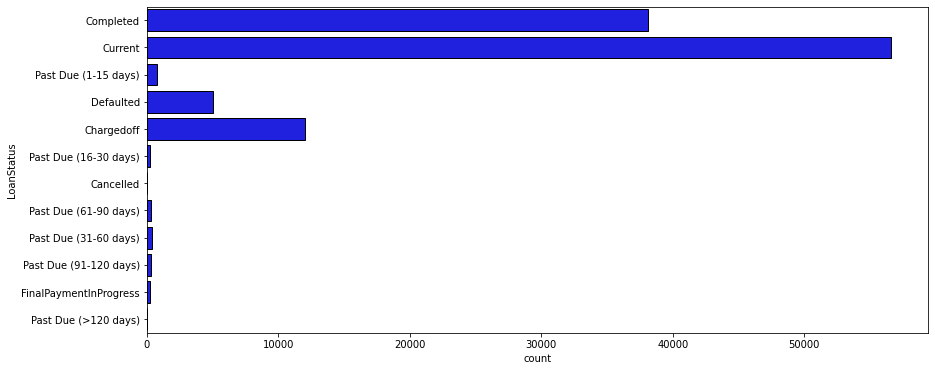

In [9]:
plt.figure(figsize=[14, 6])
sb.countplot(data=loan, y='LoanStatus', color='blue', edgecolor='black')

The Completed category dwarfs all other categories.

I think I should limit my investigations to 2008.

Because all those loans terms should've been completed by 2014 (the longest term is 5 years and 2013-5=2008).

In [21]:
loans_to_2008 = (loan[loan['ListingCreationDate'].dt.year <= 2008]).copy()

<AxesSubplot:xlabel='count', ylabel='LoanStatus'>

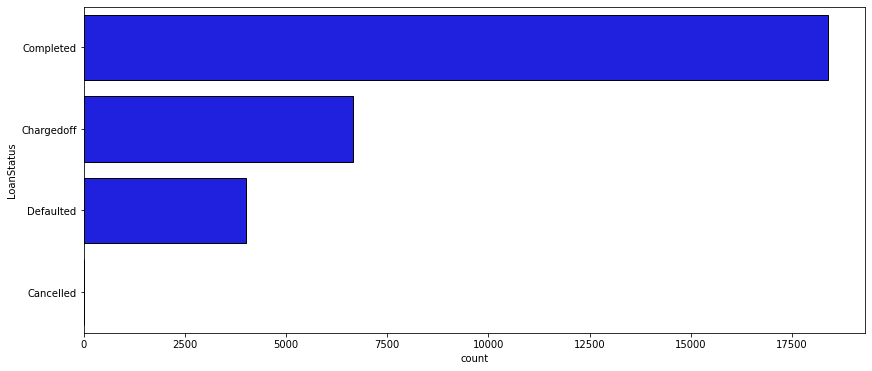

In [4]:
plt.figure(figsize=[14, 6])
sb.countplot(data=loans_to_2008, y='LoanStatus', color='blue', edgecolor='black')

In [13]:
loans_to_2008[loans_to_2008['LoanStatus'] == 'Cancelled'].count()

ListingKey                     5
ListingNumber                  5
ListingCreationDate            5
CreditGrade                    5
Term                           5
                              ..
PercentFunded                  5
Recommendations                5
InvestmentFromFriendsCount     5
InvestmentFromFriendsAmount    5
Investors                      5
Length: 81, dtype: int64

I looked at the loans created from 2005 to 2008. 

All of those loans's original terms were up by 2014, when they stopped updating our data. Most were completed, but a significate number where charged off or defaulted. Only 5 loans were cancelled. 

Default status is generally declared when a loan is 121 past due. The loan is generally charged off (ie: all hope is abandoned for the recovery of the debt) after 150 days past due. 

It is strange that there's so many loans that are still lingering in Defaulted. 

I should check to see what percentage of the defaulted loans are 5-year loans from 2008. But first I want to look at the above data in terms of percentages.

In [14]:
loans_to_2008.LoanStatus.value_counts()

Completed     18385
Chargedoff     6654
Defaulted      4012
Cancelled         5
Name: LoanStatus, dtype: int64

In [15]:
loans_to_2008.LoanStatus.value_counts().sum()

29056

From 2005 through 2008, Prosper made 29056 loans. By 2014, 18385 loans were completed, 6654 were charged off, 4012 were defaulted, and 5 were cancelled.

<Figure size 1008x432 with 0 Axes>

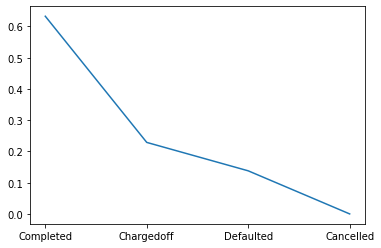

In [21]:
# find the total number of loans created from 2005 through 2008
total = loans_to_2008.LoanStatus.value_counts().sum()
# find the percentage of loans in each category of LoanStatus
percentage = loans_to_2008.LoanStatus.value_counts()/total
# list the LoanStatus categories
category = loans_to_2008.LoanStatus.unique()
plt.figure(figsize=[14, 6])
fig, ax = plt.subplots()
ax.plot(category, percentage)

<BarContainer object of 4 artists>

<Figure size 1008x432 with 0 Axes>

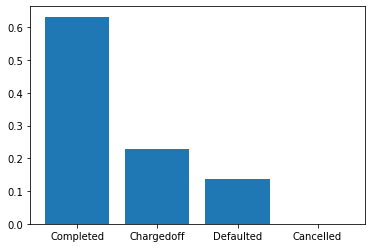

In [22]:
# I think it is easier to see with a bar chart

# find the total number of loans created from 2005 through 2008
total = loans_to_2008.LoanStatus.value_counts().sum()
# find the percentage of loans in each category of LoanStatus
percentage = loans_to_2008.LoanStatus.value_counts()/total
# list the LoanStatus categories
category = loans_to_2008.LoanStatus.unique()
plt.figure(figsize=[14, 6])
fig, ax = plt.subplots()
ax.bar(category, percentage)

In [25]:
# I want to know what percent of the Defaulted loans are five year loans
loans_to_2008.groupby('Term').sum()

,ListingNumber,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
Term,,,,,,,,,,,,,,,,,,,,,
12,319654,0.23135,0.08200,0.0720,0.0,0.0,0.0,0.0,0.0,7,...,-5.09,0.0000,0.00,0.000000e+00,0.00,1.000,0,1,100.00,105
36,5861854010,5688.81977,5325.23955,5027.9006,0.0,0.0,0.0,0.0,0.0,34899,...,-1597901.02,-926460.7657,47894492.13,4.643645e+07,2215805.94,29055.011,3978,1989,1519454.88,3373619


Oh!

All these loans were supposed to be paid in either one or three years.

I don't understand how any could still be in the Defaulted, rather than the ChargedOff category in 2014.

I guess these are cases when people had been paying a little for a long time but then stopped paying altogether a little before they stopped collecting data? How could there be so many loans that were 121 days past due but not yet 150 days past due? It doesn't make sense.

I think it is safe to say that a loan that is either still defaulted or completely charged off several (or more) years after it should've been completely paid off was an unsuccessful loan.

So let's combine the Chargedoff and Defaulted categories into one category "UnSuccesful Loans", and rename "Completed" as "Successful Loans".


In [9]:
'''
Ignore this and the next cell -- they were an early estimate of Successful vs Unsuccessful counts

# this colum will have five Succesful Loans too many because the Cancelled loans will be rolled into that category.
# 5 does not seem statistically significant, so at least for this stage, I don't think it matters
loans_to_2008['NewLoanStatus'] = np.where(loans_to_2008['LoanStatus'].isin(['ChargedOff', 'Defaulted']), 'Unsuccessful', 'Successful')


# find the total number of loans created from 2005 through 2008
total = loans_to_2008.NewLoanStatus.value_counts().sum()
# find the percentage of loans in each category of LoanStatus
percentage = loans_to_2008.NewLoanStatus.value_counts()/total
# list the LoanStatus categories
category = loans_to_2008.NewLoanStatus.unique()
plt.figure(figsize=[14, 6])
fig, ax = plt.subplots()
ax.bar(category, percentage)
'''

"\nIgnore this and the next cell -- they were an early estimate of Successful vs Unsuccessful counts\n\n# this colum will have five Succesful Loans too many because the Cancelled loans will be rolled into that category.\n# 5 does not seem statistically significant, so at least for this stage, I don't think it matters\nloans_to_2008['NewLoanStatus'] = np.where(loans_to_2008['LoanStatus'].isin(['ChargedOff', 'Defaulted']), 'Unsuccessful', 'Successful')\n\n\n# find the total number of loans created from 2005 through 2008\ntotal = loans_to_2008.NewLoanStatus.value_counts().sum()\n# find the percentage of loans in each category of LoanStatus\npercentage = loans_to_2008.NewLoanStatus.value_counts()/total\n# list the LoanStatus categories\ncategory = loans_to_2008.NewLoanStatus.unique()\nplt.figure(figsize=[14, 6])\nfig, ax = plt.subplots()\nax.bar(category, percentage)\n"

In [15]:
'''
successful = (loans_to_2008.NewLoanStatus == 'Successful').value_counts()/total
successful
'''

True     0.861922
False    0.138078
Name: NewLoanStatus, dtype: float64

I am going to combine the chargedoff and defaulted LoanStatus categories into a category called Unsuccessful. 

The completed loans I will call Successful.

In [6]:
# get current unique values
loans_to_2008['LoanStatus'].unique()

array(['Completed', 'Chargedoff', 'Defaulted', 'Cancelled'], dtype=object)

In [7]:
# create a dictionary so you can map the values onto the new category names

dict_map = dict(zip(['Completed', 'Chargedoff', 'Defaulted', 'Cancelled'], ['Successful', 'Unsuccessful', 'Unsuccessful', 'Cancelled']))
dict_map

{'Completed': 'Successful',
 'Chargedoff': 'Unsuccessful',
 'Defaulted': 'Unsuccessful',
 'Cancelled': 'Cancelled'}

In [8]:
# map the values into the new column

loans_to_2008['NewLoanStatus'] = loans_to_2008['LoanStatus'].map(dict_map)
loans_to_2008['NewLoanStatus'].value_counts()

Successful      18385
Unsuccessful    10666
Cancelled           5
Name: NewLoanStatus, dtype: int64

<AxesSubplot:xlabel='count', ylabel='NewLoanStatus'>

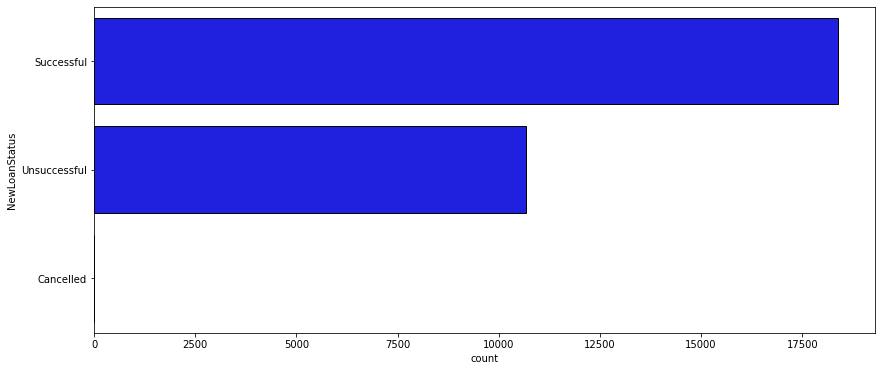

In [10]:
plt.figure(figsize=[14, 6])
sb.countplot(data=loans_to_2008, y='NewLoanStatus', color='blue', edgecolor='black')

I want to look at the percentages of loans that ended up being either successful or unsuccessful.

<BarContainer object of 3 artists>

<Figure size 1008x432 with 0 Axes>

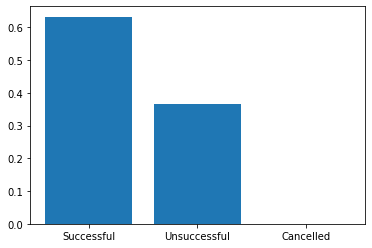

In [11]:
# find the total number of loans created from 2005 through 2008
total = loans_to_2008.NewLoanStatus.value_counts().sum()
# find the percentage of loans in each category of LoanStatus
percentage = loans_to_2008.NewLoanStatus.value_counts()/total
# list the LoanStatus categories
category = loans_to_2008.NewLoanStatus.unique()
plt.figure(figsize=[14, 6])
fig, ax = plt.subplots()
ax.bar(category, percentage)

In [12]:
total

29056

In [13]:
# the number of successful loans is 18385
# the number of total loans is 29056
18385/29056


0.6327436674008811

If we declare all loans that originated between 2005 and 2008 and that were completed by 2014 "Successful", and the rest of those loans (either Defaulted or Chargedoff, and ignoring the 5 Cancelled loans) "Unsuccessful, about 63% of the loans were successful. 

But as I did this, I began to wonder how things would look if we factored in how much money was recovered in the various "Unsuccessful" loans. So I created a return on investment (ROI) column that factored in payments and recoveries. See the top section of this notebook for the programming.

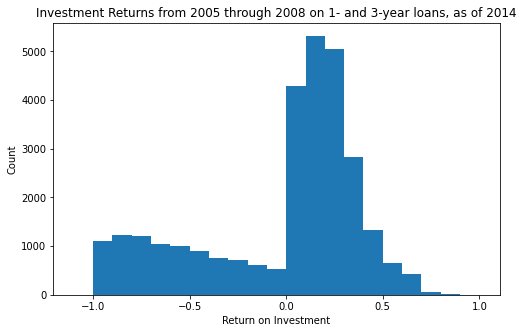

In [12]:
# start with a standard-scaled plot
binsize = .1
bins = np.arange(-1-binsize, 1+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'ROI', bins=bins)
plt.xlabel('Return on Investment')
plt.ylabel('Count')
plt.title('Investment Returns from 2005 through 2008 on 1- and 3-year loans, as of 2014')
plt.show()

The bulk of the loans seem to have either about a 10%, 20%,or 30% return (each of these categories contains over 4000 loans). Fewer, but a still substantial amount of loans have a 40% return (around 3000 loans). About 1000 loans had a 50% return, and then the numbers drop off smoothly for 60% and 70% returns. ROIs higher than that are ver rare in the data set.

On the negative side, the -100%, -90%, and -80% ROI columns each contain about 1000 loans, and the counts drop off gradually from there to 0, where there appear to be about 500 loans where the lender broke even.

I want to look at these numbers programmatically now.

In [14]:
loans_to_2008.groupby('ROI').mean()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
ROI,,,,,,,,,,,,,,,,,,,,,
-1.000000,156181.114754,36.0,0.266755,0.252606,0.240639,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,4414.551148,4416.610656,0.00,1.0,0.086066,0.028689,33.934426,57.803279
-0.997857,19063.000000,36.0,0.234970,0.227500,0.210000,NaN,NaN,NaN,NaN,NaN,...,0.00,-1.37,6100.000000,6100.000000,11.70,1.0,0.000000,0.000000,0.000000,38.000000
-0.995550,212778.000000,36.0,0.116460,0.109500,0.099500,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,10000.000000,10000.000000,44.50,1.0,1.000000,0.000000,0.000000,315.000000
-0.994118,75377.000000,36.0,0.297760,0.290000,0.285000,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,2550.000000,2550.000000,0.00,1.0,0.000000,0.000000,0.000000,34.000000
-0.992180,21868.000000,36.0,0.295250,0.287500,0.270000,NaN,NaN,NaN,NaN,NaN,...,0.00,-2.39,2550.000000,2550.000000,17.55,1.0,0.000000,0.000000,0.000000,24.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.005920,379979.000000,36.0,0.374530,0.350000,0.340000,NaN,NaN,NaN,NaN,NaN,...,-21.79,-61.52,0.000000,0.000000,0.00,1.0,0.000000,0.000000,0.000000,14.000000
1.032613,316650.000000,36.0,0.374530,0.350000,0.340000,NaN,NaN,NaN,NaN,NaN,...,-18.33,-450.00,1003.120000,945.260000,1442.14,1.0,0.000000,0.000000,0.000000,22.000000
1.130300,231726.000000,36.0,0.370360,0.350000,0.340000,NaN,NaN,NaN,NaN,NaN,...,-8.74,-587.28,1000.000000,333.700000,1534.28,1.0,0.000000,0.000000,0.000000,18.000000


In [18]:
# create bins for the ROI values
binsize=.1
bins = np.arange(-1-binsize, 1+binsize, binsize)

roi_bins = pd.cut(loans_to_2008['ROI'], bins)

# try groupby again
loans_to_2008.groupby(roi_bins)['ROI'].count()

ROI
(-1.1, -1.0]         244
(-1.0, -0.9]         853
(-0.9, -0.8]        1225
(-0.8, -0.7]        1208
(-0.7, -0.6]        1052
(-0.6, -0.5]         994
(-0.5, -0.4]         905
(-0.4, -0.3]         747
(-0.3, -0.2]         711
(-0.2, -0.1]         612
(-0.1, 8.88e-16]     539
(8.88e-16, 0.1]     4296
(0.1, 0.2]          5317
(0.2, 0.3]          5051
(0.3, 0.4]          2829
(0.4, 0.5]          1324
(0.5, 0.6]           645
(0.6, 0.7]           421
(0.7, 0.8]            51
(0.8, 0.9]            20
(0.9, 1.0]             6
Name: ROI, dtype: int64

The most common return outcomes are 0-10% (4296 loans), 10-20% (5317 loans), 20-30% (5051 loans), 30-40% (2829) loans, and 40-50% (1324 loans). But there were six negative categories that had close to or more than 1000 loans. And the rest of the negative outcomes were over 500 -- except for the -100 through -110% category, which only 244 loans.

In [19]:
# this 8.888e-16 is confusing. I'm going to see what happens with a smaller bin size
binsize=.05
bins = np.arange(-1-binsize, 1+binsize, binsize)

roi_bins = pd.cut(loans_to_2008['ROI'], bins)

# try groupby again
loans_to_2008.groupby(roi_bins)['ROI'].count()

ROI
(-1.05, -1.0]         244
(-1.0, -0.95]         379
(-0.95, -0.9]         474
(-0.9, -0.85]         605
(-0.85, -0.8]         620
(-0.8, -0.75]         600
(-0.75, -0.7]         608
(-0.7, -0.65]         543
(-0.65, -0.6]         509
(-0.6, -0.55]         527
(-0.55, -0.5]         467
(-0.5, -0.45]         475
(-0.45, -0.4]         430
(-0.4, -0.35]         401
(-0.35, -0.3]         346
(-0.3, -0.25]         397
(-0.25, -0.2]         314
(-0.2, -0.15]         298
(-0.15, -0.1]         314
(-0.1, -0.05]         281
(-0.05, 8.88e-16]     258
(8.88e-16, 0.05]     2182
(0.05, 0.1]          2114
(0.1, 0.15]          2544
(0.15, 0.2]          2773
(0.2, 0.25]          2696
(0.25, 0.3]          2355
(0.3, 0.35]          1662
(0.35, 0.4]          1167
(0.4, 0.45]           831
(0.45, 0.5]           493
(0.5, 0.55]           451
(0.55, 0.6]           194
(0.6, 0.65]           326
(0.65, 0.7]            95
(0.7, 0.75]            34
(0.75, 0.8]            17
(0.8, 0.85]            11
(0.85, 0

OK, never mind. That 8.888e-16 must be how pd.cut() gets around zero. I don't understand why it is afraid of zero, but I'll leave it alone.

### Distributions of a predictor variables 

Now I'll look at the distributions of variables whose affect on loan outcomes I want to study.

#### Income Ranges

<AxesSubplot:xlabel='count', ylabel='IncomeRange'>

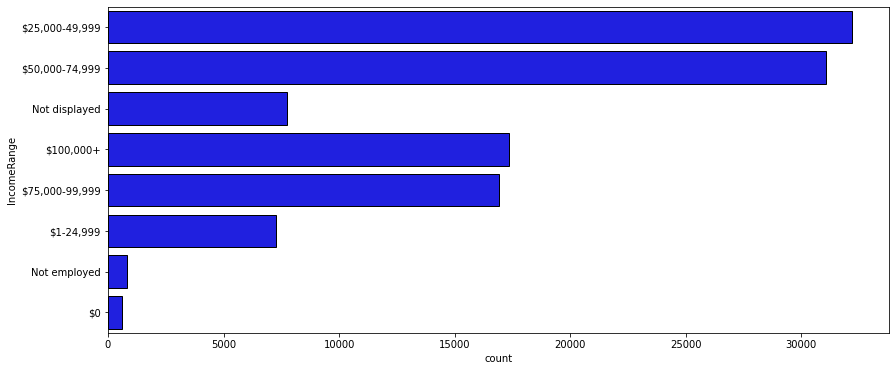

In [18]:
plt.figure(figsize=[14, 6])
sb.countplot(data=loans_to_2008, y='IncomeRange', color='blue', edgecolor='black')


I want to put these columns in order from highest to lowest.

First I need to see all the column names clearly.

In [43]:
loan.groupby('IncomeRange').count()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
IncomeRange,,,,,,,,,,,,,,,,,,,,,
$0,621,621,621,576,621,621,606,621,621,621,...,621,621,621,621,621,621,621,621,621,621
"$1-24,999",7274,7274,7274,2607,7274,7274,4571,7274,7274,7274,...,7274,7274,7274,7274,7274,7274,7274,7274,7274,7274
"$100,000+",17337,17337,17337,2116,17337,17337,6064,17337,17337,17337,...,17337,17337,17337,17337,17337,17337,17337,17337,17337,17337
"$25,000-49,999",32192,32192,32192,7977,32192,32192,16344,32192,32192,32192,...,32192,32192,32192,32192,32192,32192,32192,32192,32192,32192
"$50,000-74,999",31050,31050,31050,5378,31050,31050,12789,31050,31050,31050,...,31050,31050,31050,31050,31050,31050,31050,31050,31050,31050
"$75,000-99,999",16916,16916,16916,2401,16916,16916,6442,16916,16916,16916,...,16916,16916,16916,16916,16916,16916,16916,16916,16916,16916
Not displayed,7741,7741,7741,7741,7741,7741,7741,7716,7741,7741,...,7741,7741,7741,7741,7741,7741,7741,7741,7741,7741
Not employed,806,806,806,157,806,806,532,806,806,806,...,806,806,806,806,806,806,806,806,806,806


In [9]:
# looking up the income ranges values to check against graph outcomes
loans_to_2008['IncomeRange'].value_counts()

$25,000-49,999    8008
Not displayed     7741
$50,000-74,999    5412
$1-24,999         2617
$75,000-99,999    2417
$100,000+         2128
$0                 576
Not employed       157
Name: IncomeRange, dtype: int64

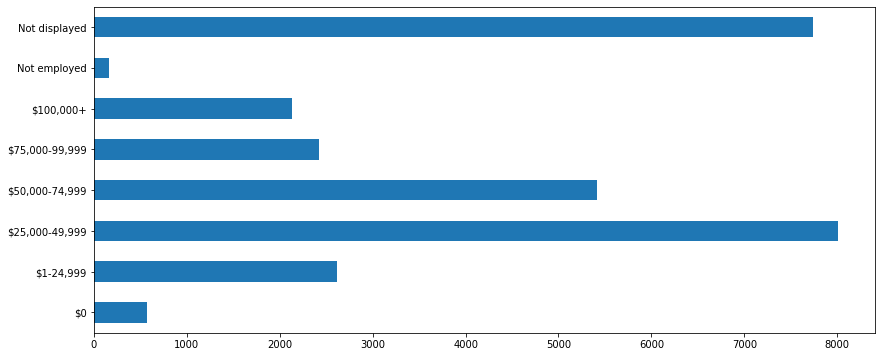

In [22]:
plt.figure(figsize=[14, 6])
order = ['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+','Not employed', 'Not displayed']
loans_to_2008['IncomeRange'] = pd.Categorical(loans_to_2008['IncomeRange'], ordered=True, categories= order)
loans_to_2008['IncomeRange'].value_counts(sort=False).plot(kind='barh');

<AxesSubplot:>

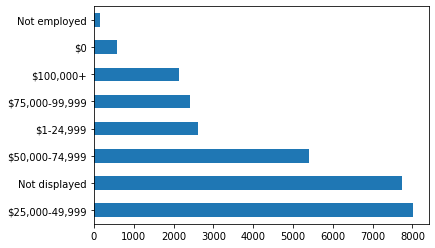

In [10]:
loans_to_2008['IncomeRange'].value_counts(sort=True).plot(kind='barh')

<AxesSubplot:>

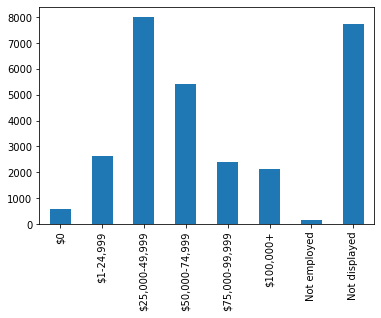

In [11]:
loans_to_2008['IncomeRange'].value_counts(sort=False).plot(kind='bar')

Of the 29058 loans made by Prosper from 2005 through 2008:

Around 8000 loans went to people at the moderate-to-low income range of \\$25K-\\$49,999. "Not Displayed" had a similar amount. The next highest category is about 5500 loans in the moderate-to-high \\$50K-\\$74,999 range. About 500 loans were made to people with no income and even fewer to unemployed people. Each of the three remaining categories (one under \\$25K and two over \\$75K) accounted for 3000 loans.

It would be interesting to see how the percentage of loans given to people at various income levels relates to the percentage of people in the country at those various income ranges.But that is outside the scope of this project.

We can say that there is a fair amount of data for all the income ranges (at least 2,000 loans for all categories except for the \\$0 income; and much more for people with in the medium income ranges). Enough that the information should be statistically significant. 

I am surprised how many incomes were not recorded. I'm not sure what to do with that category. I will perhaps exclude those loans when looking for trends in the bivariate and multivariate graphs.

Now let's look at credit grade distributions.

<AxesSubplot:xlabel='count', ylabel='CreditGrade'>

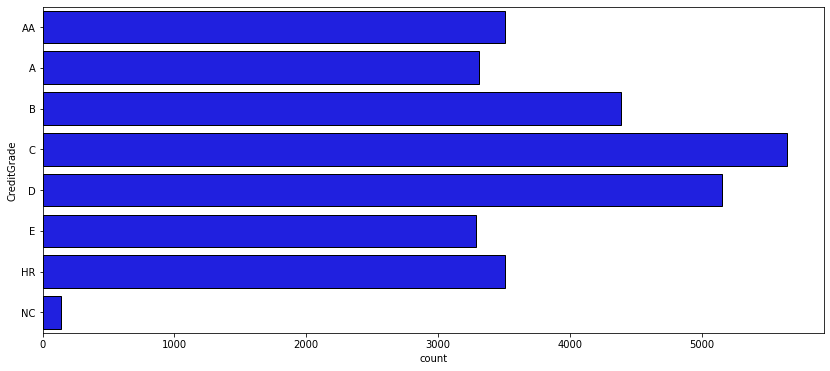

In [23]:
plt.figure(figsize=[14, 6])
order = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR','NC']
sb.countplot(data=loans_to_2008, y='CreditGrade', color='blue', edgecolor='black', order=order)

In [52]:
loans_to_2008.CreditGrade.value_counts()

C     5644
D     5151
B     4386
HR    3508
AA    3508
A     3313
E     3289
NC     141
Name: CreditGrade, dtype: int64

In [53]:
loans_to_2008.CreditGrade.value_counts().sum()

28940

In [7]:
loans_to_2008.shape[0]

29056

There seem to be few less credit ratings than total loans (29056 - 28940 = 16).

I am surprised that the AA, A, and B credit ratings total about 13,000 loans. B

If you add up the income levels from \\$50,000 to \\$100,000+, you get less than 10,000 total loans.

Of course there's the large "Not Displayed" section in the IncomeRange column. I may have to remove those people from the final analysis. It might make it difficult to speak meaningfully about income ranges in multivariate plots.

It is also interesting to see how willing Prosper is to loan to people with iffy to very low credit ratings. C is the largest category; D is the second largest category; and E is also pretty large.

I guess the Credit Rating distributions actually correlates pretty well with the Income Range distributions: The bulk of the borrowers were in medium income ranges. They probably don't get the very best loan terms. So the highest credit ratings probably went to the relatively few high income borrowers; and Bs and Cs probably went to the medium-high earners; and Cs and Ds probably went to the medium-low earners. We could investigate this when we do the bivariate graphs.

I don't know what HR means.

#### Debt to Income ratio.


(array([2.7324e+04, 1.3500e+02, 4.2000e+01, 2.7000e+01, 1.7000e+01,
        1.3000e+01, 5.0000e+00, 6.0000e+00, 2.0000e+00, 2.2800e+02]),
 array([ 0.   ,  1.001,  2.002,  3.003,  4.004,  5.005,  6.006,  7.007,
         8.008,  9.009, 10.01 ]),
 <BarContainer object of 10 artists>)

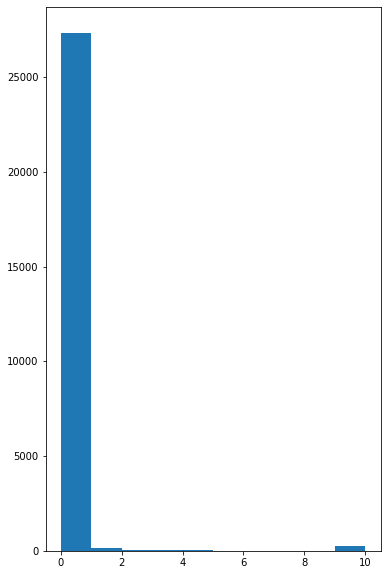

In [24]:
plt.figure(figsize=[6, 10])

plt.hist(data = loans_to_2008, x='DebtToIncomeRatio')

Ratios above 1 are very rare. I guess those people are in a bad way.

Since they owe more than they make in a year.

It is weird that the largest outlier is like 9 to 10. Are we to believe there are people who owe ten times what they make in a year? And Prosper still gave them loans??

Let's zoom in to 0 to 1 range to see what kind of variation there is there.

(0.0, 2.0)

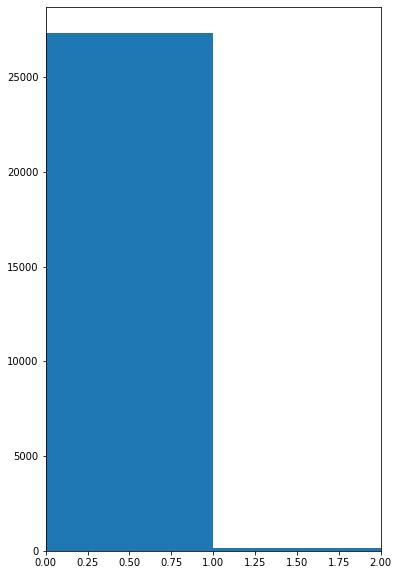

In [9]:
plt.figure(figsize=[6, 10])

plt.hist(data = loans_to_2008, x='DebtToIncomeRatio')

plt.xlim(0, 2)

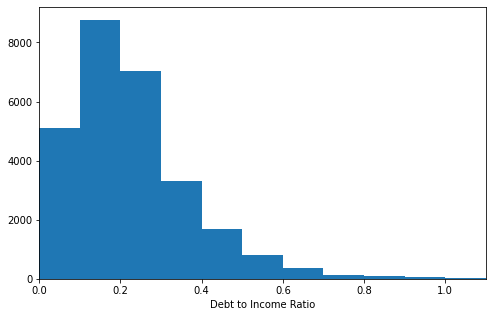

In [25]:
# I need to adjust the bin sizes

binsize = .1
bins = np.arange(0, loans_to_2008['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
#plt.xticks(rotation)
plt.xlim(0, 1.1)
plt.show()

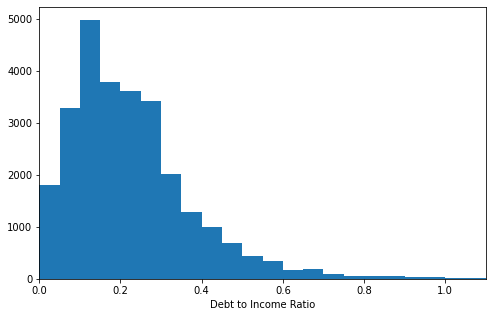

In [8]:

binsize = .05
bins = np.arange(0, loans_to_2008['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
#plt.xticks(rotation)
plt.xlim(0, 1.1)
plt.show()

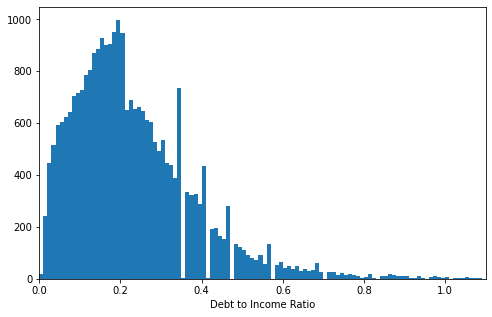

In [9]:
binsize = .01
bins = np.arange(0, loans_to_2008['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
#plt.xticks(rotation)
plt.xlim(0, 1.1)
plt.show()

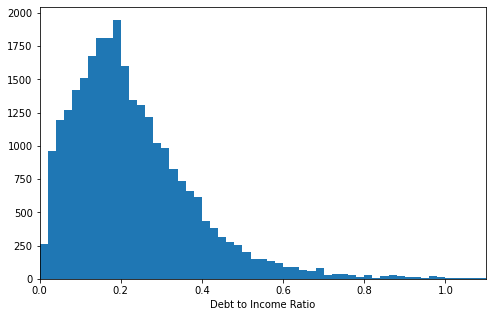

In [10]:
binsize = .02
bins = np.arange(0, loans_to_2008['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
#plt.xticks(rotation)
plt.xlim(0, 1.1)
plt.show()

See below a log transformation of the same data.

I don't see the advantage between that graph and one that zooms in on the 0 to 1 range and notes that there are a very few extreme outliers.

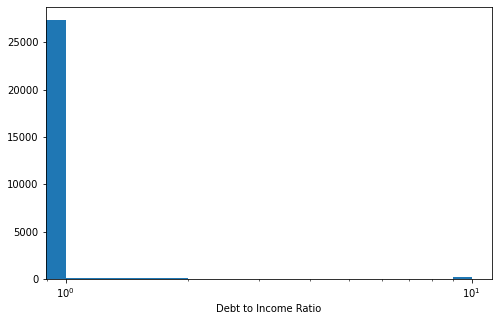

In [9]:
def log_trans(x, inverse=False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10,x)

#binsize = .02
#bins = 10**np.arange(0, loans_to_2008['DebtToIncomeRatio'].max()+binsize, binsize)

#x_tick_locs = np.array([.1, .3, .5, .7, 1, 100, 300, 1000])

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio')
plt.xlabel('Debt to Income Ratio')
plt.xscale('log')
#plt.xticks(x_tick_locs, x_tick_locs)
#plt.xticks(rotation=45)

plt.show()

I don't think using a log transformation will help here.

It isn't just a long tale. It is a giant gap between fractions less than 1 and 10.

I fiddle around with the graph a little below, but the results are less satisfying than zooming in and noting that there are a very few outliers whose debts far exceed their incomes.

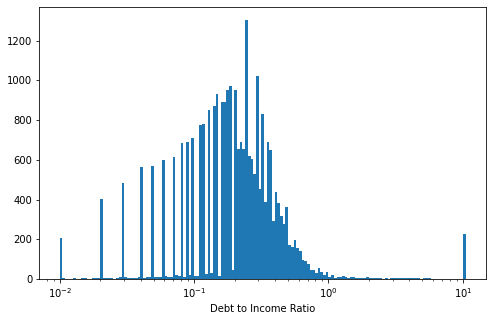

In [13]:
def log_trans(x, inverse=False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10,x)

binsize = .02
bins = 10**np.arange(-2, np.log10(loans_to_2008['DebtToIncomeRatio'].max())+binsize, binsize)

#x_tick_locs = np.array([.1, .3, .5, .7, 1, 100, 300, 1000])

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins=bins)
plt.xlabel('Debt to Income Ratio')
plt.xscale('log')
#plt.xticks(x_tick_locs, x_tick_locs)
#plt.xticks(rotation=45)

plt.show()

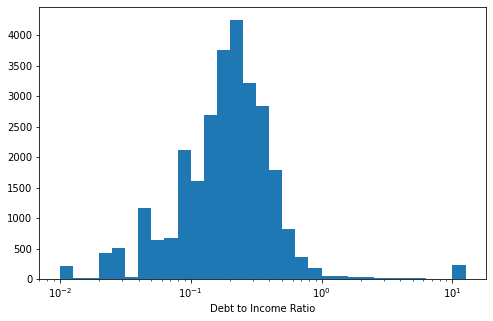

In [14]:
def log_trans(x, inverse=False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10,x)

binsize = .1
bins = 10**np.arange(-2, np.log10(loans_to_2008['DebtToIncomeRatio'].max())+binsize, binsize)

#x_tick_locs = np.array([.1, .3, .5, .7, 1, 100, 300, 1000])

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins=bins)
plt.xlabel('Debt to Income Ratio')
plt.xscale('log')
#plt.xticks(x_tick_locs, x_tick_locs)
#plt.xticks(rotation=45)

plt.show()

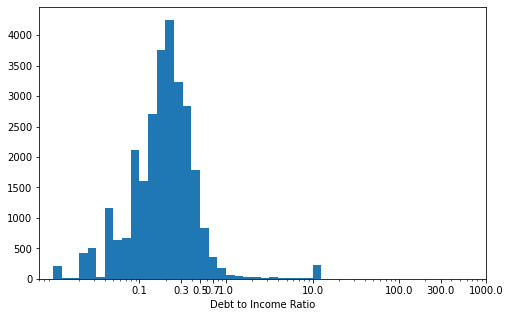

In [16]:
def log_trans(x, inverse=False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10,x)

binsize = .1
bins = 10**np.arange(-2, np.log10(loans_to_2008['DebtToIncomeRatio'].max())+binsize, binsize)

x_tick_locs = np.array([.1, .3, .5, .7, 1, 10, 100, 300, 1000])

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins=bins)
plt.xlabel('Debt to Income Ratio')
plt.xscale('log')
plt.xticks(x_tick_locs, x_tick_locs)
#plt.xticks(rotation=45)

plt.show()

The vast majority of the loans are given to people who's debt-to-income ratio is less than 1.

Of those, there are a lot of people with ratios from 0 to .1; but almost twice as many with ratios from .1 to .2; it tapers down from this height, with .3 having more loans than .1 but less than .2, and then a pretty quick drop-off.

This makes sense. Most people who need loans are exceeding their income at least somewhat, but you usually can't get a loan if you are exceeding your income by too much. I guess the bulk of lendees are living 20 to 30 percent above their incomes.

But who are these people that owe ten times what they make?

In [13]:
loans_to_2008[loans_to_2008['DebtToIncomeRatio'] > 9].head(20)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewLoanStatus,ROI
226,2EA63382419173023274969,104542,2007-02-28 10:45:44.153,D,36,Completed,2009-07-07 00:00:00,0.11749,0.1000,0.0900,...,0.00,0.00,0.00,1.0,0,0,0.0,16,Successful,0.111060
576,3C18338635952151669AA4C,124494,2007-04-16 17:44:06.780,AA,36,Completed,2007-06-28 00:00:00,0.10505,0.0935,0.0885,...,0.00,0.00,0.00,1.0,0,0,0.0,58,Successful,0.016200
1242,029C3391969521662B80577,146341,2007-06-03 20:32:32.783,A,36,Completed,2010-05-25 00:00:00,0.11415,0.1072,0.0997,...,0.00,0.00,0.00,1.0,0,0,0.0,87,Successful,0.178200
1925,02F1339019841280370DC32,139992,2007-05-19 11:14:54.370,A,36,Defaulted,2010-09-29 00:00:00,0.08684,0.0800,0.0650,...,34.60,-34.34,32.62,1.0,1,1,750.0,19,Unsuccessful,0.144523
2217,7FF33379485792378896C12,91476,2007-01-31 14:16:07.313,C,36,Completed,2009-12-29 00:00:00,0.16436,0.1572,0.1472,...,0.00,0.00,0.00,1.0,0,0,0.0,179,Successful,0.240116
2394,45B43387230086794000897,128885,2007-04-25 22:12:59.947,AA,36,Defaulted,2007-11-01 00:00:00,0.18726,0.1800,0.1750,...,3916.54,3916.54,0.00,1.0,0,0,0.0,90,Unsuccessful,-0.963422
2715,426D33702731866796C69D2,47155,2006-10-11 11:33:03.480,B,36,Completed,2009-10-30 00:00:00,0.18224,0.1750,0.1650,...,0.00,0.00,0.00,1.0,0,0,0.0,72,Successful,0.292953
3494,423A33896243107125B04BB,138087,2007-05-15 17:42:32.200,D,36,Chargedoff,2008-12-25 00:00:00,0.22744,0.2200,0.2100,...,2997.98,2997.98,0.00,1.0,0,0,0.0,52,Unsuccessful,-0.439931
4827,0EDB3387076244781A19AB4,126753,2007-04-21 10:11:30.990,AA,36,Completed,2007-08-02 00:00:00,0.08971,0.0725,0.0625,...,0.00,0.00,0.00,1.0,0,0,0.0,33,Successful,0.017990
4968,48D03387495590363EC0F0B,127212,2007-04-22 17:40:44.490,A,36,Defaulted,2009-05-01 00:00:00,0.18726,0.1800,0.1750,...,13455.94,13455.94,0.00,1.0,1,1,1200.0,401,Unsuccessful,-0.290808


In [16]:
loans_to_2008[loans_to_2008['DebtToIncomeRatio'] > 9][["DebtToIncomeRatio", "CreditGrade", "IncomeRange", "ROI"]].head(30)

,DebtToIncomeRatio,CreditGrade,IncomeRange,ROI
226,10.01,D,Not displayed,0.111060
576,10.01,AA,"$1-24,999",0.016200
1242,10.01,A,Not employed,0.178200
1925,10.01,A,Not employed,0.144523
2217,10.01,C,Not displayed,0.240116
2394,10.01,AA,Not employed,-0.963422
2715,10.01,B,Not displayed,0.292953
3494,10.01,D,Not employed,-0.439931
4827,10.01,AA,"$1-24,999",0.017990
4968,10.01,A,"$1-24,999",-0.290808


In [21]:
loans_to_2008[loans_to_2008['DebtToIncomeRatio'] > 9]["CreditGrade"].count()

228

In [31]:
loans_to_2008[(loans_to_2008['DebtToIncomeRatio'] < 9) & (loans_to_2008['DebtToIncomeRatio'] > 5)]["CreditGrade"].count()

25

In [32]:
loans_to_2008[(loans_to_2008['DebtToIncomeRatio'] < 5) & (loans_to_2008['DebtToIncomeRatio'] > 3)]["CreditGrade"].count()

44

In [33]:
loans_to_2008[(loans_to_2008['DebtToIncomeRatio'] < 3) & (loans_to_2008['DebtToIncomeRatio'] > 2)]["CreditGrade"].count()

42

In [35]:
loans_to_2008[(loans_to_2008['DebtToIncomeRatio'] < 2) & (loans_to_2008['DebtToIncomeRatio'] > 1)]["CreditGrade"].count()

135

In [37]:
loans_to_2008[loans_to_2008['DebtToIncomeRatio'] < 1].count()

ListingKey                     27317
ListingNumber                  27317
ListingCreationDate            27317
CreditGrade                    27212
Term                           27317
                               ...  
InvestmentFromFriendsCount     27317
InvestmentFromFriendsAmount    27317
Investors                      27317
NewLoanStatus                  27317
ROI                            27317
Length: 83, dtype: int64

In [8]:
# looking at the debt to income ratios programmatically

binsize = .1
bins = np.arange(0, loans_to_2008['DebtToIncomeRatio'].max()+binsize, binsize)
bins=[round(x,1) for x in bins]
labels = [f'''{bins[i]} - {bins[i +1]}''' for i in range (len(bins) -1)]

loans_to_2008['dti_bins'] = pd.cut(loans_to_2008['DebtToIncomeRatio'], bins, labels=labels, include_lowest=True)

# try groupby again
loans_to_2008.groupby('dti_bins')['DebtToIncomeRatio'].count()

dti_bins
0.0 - 0.1      5800
0.1 - 0.2      8999
0.2 - 0.3      6085
0.3 - 0.4      3536
0.4 - 0.5      1543
               ... 
9.6 - 9.7         0
9.7 - 9.8         1
9.8 - 9.9         0
9.9 - 10.0        0
10.0 - 10.1     226
Name: DebtToIncomeRatio, Length: 101, dtype: int64

Almost all the DTIR are less than 1. The relatively few borrowers with debt to income ratios above 1 tend to be people with either no income or very low income. I think the best way to deal with this is to zoom in on the area of interest and note that there are a very few outliers at higher DTIRs, and that these outliers tend to be people with either no or very low income.

Who are these 226 people who have debts 10 times their incomes???

Let's remove the 226 and the one person with like 9.7 times as much debt as income.

And see what we get.

In [17]:
less_than_9 = loans_to_2008[loans_to_2008['DebtToIncomeRatio'] < 9].copy()

less_than_9.groupby('dti_bins')['DebtToIncomeRatio'].count().head(20)

dti_bins
0.0 - 0.1    5800
0.1 - 0.2    8999
0.2 - 0.3    6085
0.3 - 0.4    3536
0.4 - 0.5    1543
0.5 - 0.6     687
0.6 - 0.7     353
0.7 - 0.8     152
0.8 - 0.9     109
0.9 - 1.0      60
1.0 - 1.1      29
1.1 - 1.2      17
1.2 - 1.3      18
1.3 - 1.4      15
1.4 - 1.5      13
1.5 - 1.6      15
1.6 - 1.7       6
1.7 - 1.8       7
1.8 - 1.9       6
1.9 - 2.0       9
Name: DebtToIncomeRatio, dtype: int64

The vast majority of borrowers have a debt-to-income ratio between 0 and 1. And within that range, there is quite a bit of variety. Perhaps by throwing out the few people with much higher debt-to-income ratios (which possibly skews and confuses the trends), DTIR can be a useful metric for predicting loan outcomes.

#### Amount Delinquent counts

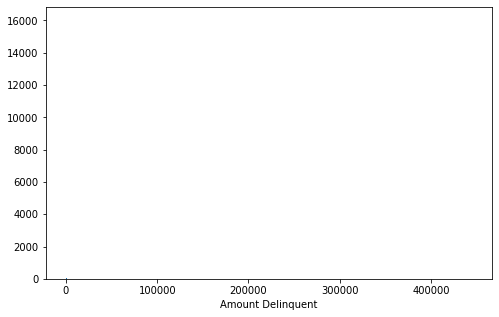

In [18]:
binsize = 25
bins = np.arange(0, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent', bins = bins)
plt.xlabel('Amount Delinquent')
#plt.xticks(rotation)
#plt.xlim(0, 1000)
plt.show()

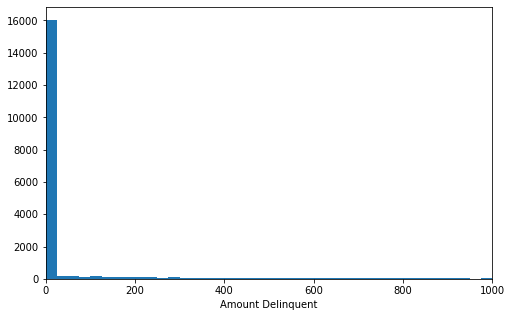

In [19]:
binsize = 25
bins = np.arange(0, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent', bins = bins)
plt.xlabel('Amount Delinquent')
#plt.xticks(rotation)
plt.xlim(0, 1000)
plt.show()

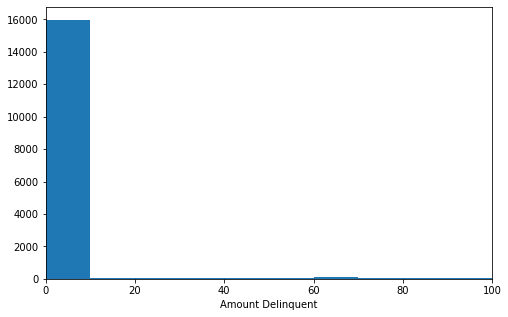

In [20]:
binsize = 10
bins = np.arange(0, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent', bins = bins)
plt.xlabel('Amount Delinquent')
#plt.xticks(rotation)
plt.xlim(0, 100)
plt.show()

In [18]:
loans_to_2008.groupby('AmountDelinquent').count()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewLoanStatus,ROI
AmountDelinquent,,,,,,,,,,,,,,,,,,,,,
0.0,15944,15944,15944,15840,15944,15944,15944,15944,15944,15944,...,15944,15944,15944,15944,15944,15944,15944,15944,15944,15944
1.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2.0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
3.0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160039.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
161344.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
161475.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [21]:
binsize = 10
# we have to exclude zero because many of the borrowers are $0 delinquent and pd.cut() can't handle zero
bins = np.arange(.1, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

dti_bins = pd.cut(loans_to_2008['AmountDelinquent'], bins)

# try groupby again
(loans_to_2008.groupby(dti_bins)['AmountDelinquent'].count()).head(10)

AmountDelinquent
(0.1, 10.1]      38
(10.1, 20.1]     41
(20.1, 30.1]     58
(30.1, 40.1]     63
(40.1, 50.1]     66
(50.1, 60.1]     66
(60.1, 70.1]     76
(70.1, 80.1]     65
(80.1, 90.1]     54
(90.1, 100.1]    58
Name: AmountDelinquent, dtype: int64

In [22]:
binsize = 100
bins = np.arange(.1, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

dti_bins = pd.cut(loans_to_2008['AmountDelinquent'], bins)

# try groupby again
(loans_to_2008.groupby(dti_bins)['AmountDelinquent'].count()).head(10)

AmountDelinquent
(0.1, 100.1]       585
(100.1, 200.1]     441
(200.1, 300.1]     365
(300.1, 400.1]     250
(400.1, 500.1]     196
(500.1, 600.1]     182
(600.1, 700.1]     171
(700.1, 800.1]     144
(800.1, 900.1]     131
(900.1, 1000.1]     96
Name: AmountDelinquent, dtype: int64

In [23]:
binsize = 1000
bins = np.arange(.1, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

dti_bins = pd.cut(loans_to_2008['AmountDelinquent'], bins)

# try groupby again
(loans_to_2008.groupby(dti_bins)['AmountDelinquent'].count()).head(10)

AmountDelinquent
(0.1, 1000.1]        2561
(1000.1, 2000.1]      745
(2000.1, 3000.1]      443
(3000.1, 4000.1]      298
(4000.1, 5000.1]      217
(5000.1, 6000.1]      194
(6000.1, 7000.1]      143
(7000.1, 8000.1]      107
(8000.1, 9000.1]      101
(9000.1, 10000.1]      58
Name: AmountDelinquent, dtype: int64

In [24]:
binsize = 5000
bins = np.arange(0, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

dti_bins = pd.cut(loans_to_2008['AmountDelinquent'], bins)

# try groupby again
(loans_to_2008.groupby(dti_bins)['AmountDelinquent'].count()).head(10)

AmountDelinquent
(0.0, 5000.0]         4264
(5000.0, 10000.0]      603
(10000.0, 15000.0]     253
(15000.0, 20000.0]     128
(20000.0, 25000.0]      79
(25000.0, 30000.0]      49
(30000.0, 35000.0]      37
(35000.0, 40000.0]      15
(40000.0, 45000.0]       9
(45000.0, 50000.0]      10
Name: AmountDelinquent, dtype: int64

In [22]:
loans_to_2008.groupby('dti_bins')['AmountDelinquent'].count().sum()

20321

The Amount Delinquent has an insanely long and uniformly low tale.

Most all of the amounts are around $100 or less.

But there are some that are more than $30K

I will try a log transformation.

In [23]:
# what is the max value for the Amount Delinquent column?

loans_to_2008.groupby('AmountDelinquent').describe()

ListingNumber                                          \
                         count           mean            std       min   
AmountDelinquent                                                         
0.0                    15944.0  265256.862331   91082.353435   98299.0   
1.0                        2.0  205357.500000  107455.482003  129375.0   
2.0                        3.0  221115.333333   96350.843932  117039.0   
3.0                        3.0  216106.333333   92259.931088  123684.0   
4.0                        2.0  118920.500000   11988.995475  110443.0   
...                        ...            ...            ...       ...   
160039.0                   1.0  294353.000000            NaN  294353.0   
161344.0                   1.0  280043.000000            NaN  280043.0   
161475.0                   1.0  360169.000000            NaN  360169.0   
190585.0                   1.0  162383.000000            NaN  162383.0   
444745.0                   1.0  123103.000000            NaN  123103.0   

                                                               Term  \
                        25%       50%        75%       max    count   
AmountDelinquent                                                      
0.0               188328.50  278624.5  342952.25  414823.0  15944.0   
1.0               167366.25  205357.5  243348.75  281340.0      2.0   
2.0               178070.00  239101.0  273153.50  307206.0      3.0   
3.0               170058.00  216432.0  262317.50  308203.0      3.0   
4.0               114681.75  118920.5  123159.25  127398.0      2.0   
...                     ...       ...        ...       ...      ...   
160039.0          294353.00  294353.0  294353.00  294353.0      1.0   
161344.0          280043.00  280043.0  280043.00  280043.0      1.0   
161475.0          360169.00  360169.0  360169.00  360169.0      1.0   
190585.0          162383.00  162383.0  162383.00  162383.0      1.0   
444745.0          123103.00  123103.0  123103.00  123103.0      1.0   

                             ... Investors             ROI            \
                       mean  ...       75%    max    count      mean   
AmountDelinquent             ...                                       
0.0               35.998495  ...    209.25  913.0  15944.0  0.008028   
1.0               36.000000  ...     73.25   84.0      2.0  0.445563   
2.0               36.000000  ...    242.00  274.0      3.0  0.240855   
3.0               36.000000  ...     32.00   38.0      3.0 -0.246383   
4.0               36.000000  ...     66.25   76.0      2.0  0.236599   
...                     ...  ...       ...    ...      ...       ...   
160039.0          36.000000  ...     28.00   28.0      1.0 -0.585290   
161344.0          36.000000  ...     29.00   29.0      1.0  0.574885   
161475.0          36.000000  ...      1.00    1.0      1.0 -1.000000   
190585.0          36.000000  ...     80.00   80.0      1.0  0.388575   
444745.0          36.000000  ...     50.00   50.0      1.0 -0.707990   

                                                                              
                       std       min       25%       50%       75%       max  
AmountDelinquent                                                              
0.0               0.378535 -1.000000 -0.103129  0.132443  0.246540  1.005920  
1.0               0.120849  0.360110  0.402836  0.445563  0.488289  0.531016  
2.0               0.070708  0.177903  0.202604  0.227304  0.272331  0.317357  
3.0               0.458514 -0.697074 -0.479361 -0.261648 -0.021037  0.219573  
4.0               0.145521  0.133700  0.185150  0.236599  0.288049  0.339498  
...                    ...       ...       ...       ...       ...       ...  
160039.0               NaN -0.585290 -0.585290 -0.585290 -0.585290 -0.585290  
161344.0               NaN  0.574885  0.574885  0.574885  0.574885  0.574885  
161475.0               NaN -1.000000 -1.000000 -1.000000 -1.000000 -1.000000  
190585.0               NaN  

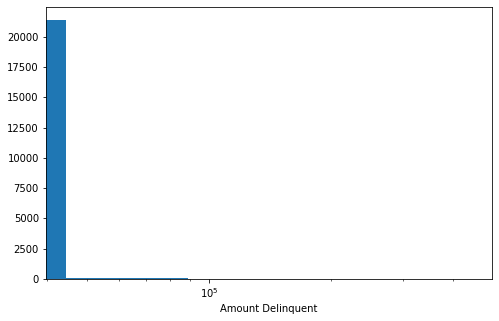

In [18]:
plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent')
plt.xscale('log')

plt.xlabel('Amount Delinquent')
plt.show()

In [ ]:
plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent')
plt.xscale('log')

plt.xlabel('Amount Delinquent')
plt.show()

In [ ]:
'''
# Get the ticks for bins between [0 - maximum weight]
bins = 10 ** np.arange(-1, 3+0.1, 0.1)

# Generate the x-ticks you want to apply
ticks = [0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]
# Convert ticks into string values, to be displaye dlong the x-axis
labels = ['{}'.format(v) for v in ticks]

# Plot the histogram
plt.hist(data=pokemon, x='weight', bins=bins);

# The argument in the xscale() represents the axis scale type to apply.
# The possible values are: {"linear", "log", "symlog", "logit", ...}
plt.xscale('log')

# Apply x-ticks
plt.xticks(ticks, labels);


plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent')
plt.xscale('log')

plt.xlabel('Amount Delinquent')
plt.show()
'''

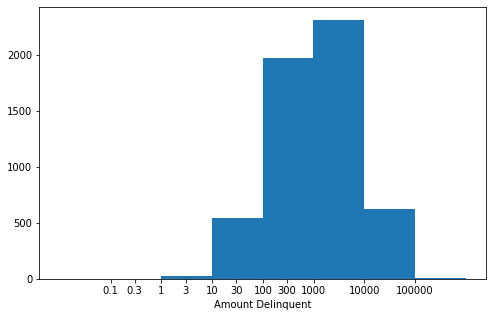

In [25]:
binsize = .999
bins = 10**np.arange(-2, np.log10(loans_to_2008['AmountDelinquent'].max())+binsize, binsize)

# Generate the x-ticks you want to apply
ticks = [0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 10000, 100000]
# Convert ticks into string values, to be displaye dlong the x-axis
labels = ['{}'.format(v) for v in ticks]

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent', bins=bins)
plt.xscale('log')
plt.xticks(ticks, labels)

plt.xlabel('Amount Delinquent')
plt.show()

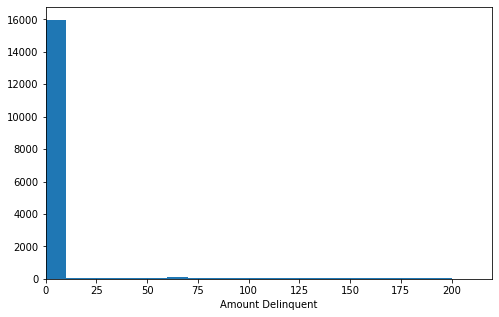

In [64]:
binsize = 10
bins = np.arange(0, 210, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent', bins=bins)
plt.xlim(0, 220)

plt.xlabel('Amount Delinquent')
plt.show()

There is a wide distribution of values for Amount Delinquent. A difficulty is that many are zero values, but log transformations can't handle zero values. I could do a log transformation, but note the number of people who have no debt dwarfs the graphed values.

In [28]:
# number of people who are not at all delinquent
loans_to_2008[loans_to_2008["AmountDelinquent"]==0].count()

ListingKey                     15944
ListingNumber                  15944
ListingCreationDate            15944
CreditGrade                    15840
Term                           15944
                               ...  
InvestmentFromFriendsCount     15944
InvestmentFromFriendsAmount    15944
Investors                      15944
NewLoanStatus                  15944
ROI                            15944
Length: 83, dtype: int64

In [29]:
# of people with some delinquency

loans_to_2008[loans_to_2008["AmountDelinquent"]>0].count()

ListingKey                     5490
ListingNumber                  5490
ListingCreationDate            5490
CreditGrade                    5478
Term                           5490
                               ... 
InvestmentFromFriendsCount     5490
InvestmentFromFriendsAmount    5490
Investors                      5490
NewLoanStatus                  5490
ROI                            5490
Length: 83, dtype: int64

See? 15,944 borrowers are \\$0 delinquent. 5,490 are to some degree delinquent.

Let's look at three categorical values: IsBorrowerHomeowner, BorrowerState, Occupation

<AxesSubplot:>

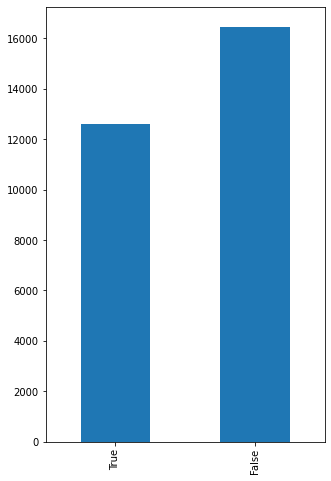

In [6]:
plt.figure(figsize=[5,8])

loans_to_2008['IsBorrowerHomeowner'].value_counts(sort=False).plot(kind='bar')

About 20% of the lenders owned homes than didn't.

<AxesSubplot:>

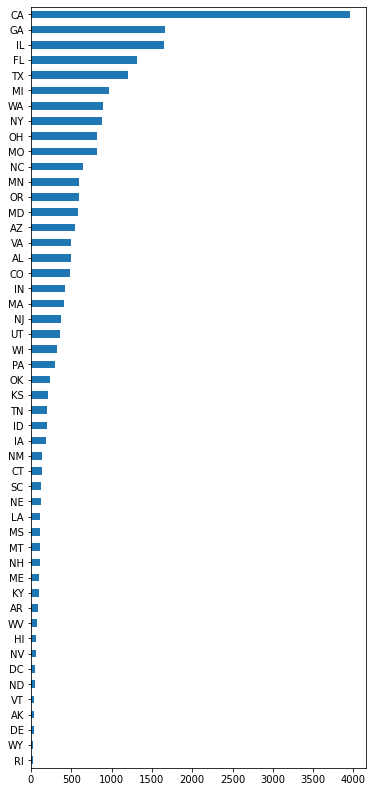

In [10]:
plt.figure(figsize=[6,14])

loans_to_2008['BorrowerState'].value_counts(sort=True, ascending=True).plot(kind='barh')

More than twice as many lenders were from CA than from the second highest ranking state (GA). CA is a very populous state. The numbers 3, 4, and 5 states are also very populous: IL, FL, TX. GA has a large population, but smaller than IL, FL, or TX. 

I looked up the most populous states.
https://www.statista.com/statistics/183497/population-in-the-federal-states-of-the-us/

Top 10 in Millions:

CA (39.7), TX (29.4), FL (21.7), NY (19.3), PA (12.8), IL (12.6), OH (11.7), GA (10.71), NC (10.6), MI (9.97)

Compare with the top 10 most lended-to (by Prosper 2005-2008):

CA, GA, IL, FL, TX, MI, WA, NY, OH, MO

Clearly factors besides the population of the state affect how many of its inhabitants took out a prosper loan, although many of the largest states also took out the most loans.

<AxesSubplot:>

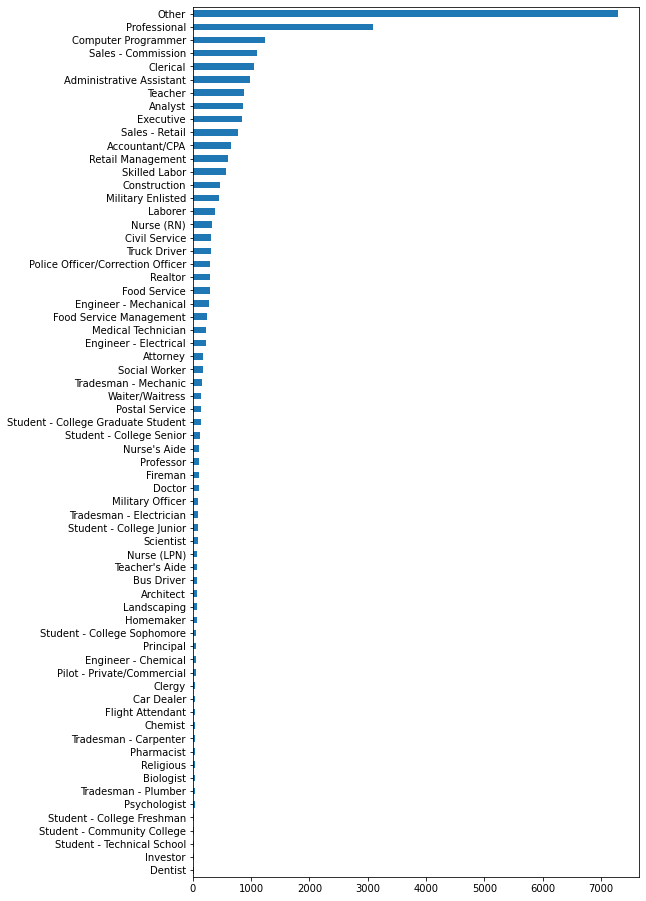

In [12]:
plt.figure(figsize=[8,16])

loans_to_2008['Occupation'].value_counts(sort=True, ascending=True).plot(kind='barh')

In [17]:
occupations = (loans_to_2008['Occupation'].value_counts(sort=True, ascending=False)).copy()
occupations.head(20)

Other                                7296
Professional                         3085
Computer Programmer                  1241
Sales - Commission                   1096
Clerical                             1047
Administrative Assistant              980
Teacher                               869
Analyst                               866
Executive                             843
Sales - Retail                        766
Accountant/CPA                        658
Retail Management                     601
Skilled Labor                         564
Construction                          464
Military Enlisted                     447
Laborer                               378
Nurse (RN)                            328
Civil Service                         317
Truck Driver                          308
Police Officer/Correction Officer     299
Name: Occupation, dtype: int64

I don't see how useful this can be. By far the biggest category is "Other" (7296), followed by the generic "Professional" (3085). After that, only Computer Programmer, Sales - Commission and Clerical break 1000.

#### Credit Score Range

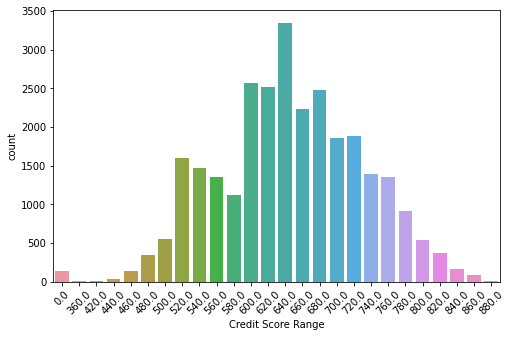

In [51]:
plt.figure(figsize=[8, 5])
sb.countplot(data = loans_to_2008, x = 'CreditScoreRangeLower')
plt.xlabel('Credit Score Range')
plt.xticks(rotation=45);

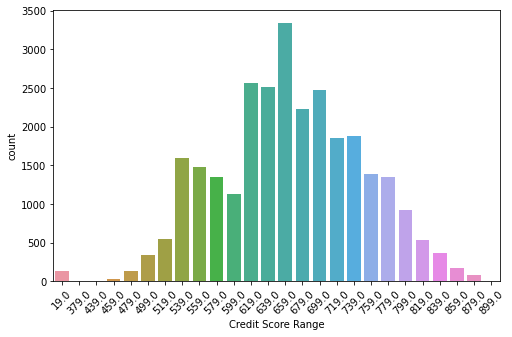

In [52]:
plt.figure(figsize=[8, 5])
sb.countplot(data = loans_to_2008, x = 'CreditScoreRangeUpper')
plt.xlabel('Credit Score Range')
plt.xticks(rotation=45);

In [40]:
csru = pd.unique(loans_to_2008['CreditScoreRangeUpper'])
sorted(csru)

[19.0,
 379.0,
 439.0,
 459.0,
 479.0,
 499.0,
 519.0,
 539.0,
 559.0,
 579.0,
 599.0,
 619.0,
 639.0,
 659.0,
 679.0,
 699.0,
 719.0,
 739.0,
 759.0,
 779.0,
 799.0,
 819.0,
 839.0,
 859.0,
 nan,
 879.0,
 899.0]

Credit Score Range tends to look fairly bell-shaped. This is not true of the Credit Grades, whose population counts sloped gently downward as Credit Grade went down. Maybe I should examine the relationship between Credit Score Range and Credit Grade in the bivariate section. To see if I can understand why these apparently closely-related metrics have such different population-count graphs.

### When I decided to come up with the ROI metric

Earlier I calculated that the success rate for the loans studied here (loans made from 2005 through 2008), was about 63%. That seems like a terrible failure rate, but I didn't factor in how much money the loans that were eventually defaulted or charged off had already paid back to the lender.

I think a better metric for measuring the success of the loans would be something like: (Amount Lendee paid Lender) - (Amount of Loan + Amount spent by Lendee in quest to recover Loan).

To that end, I will create the following column:

return on investment = (payments.sum - servicefees.sum - collectionfees.sum - loanamount + nonprincipalrecovery.sum + principalrecovery.sum)/loanamount


In [26]:
loans_to_2008.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29056 entries, 0 to 113927
Data columns (total 81 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   ListingKey                           29056 non-null  object        
 1   ListingNumber                        29056 non-null  int64         
 2   ListingCreationDate                  29056 non-null  datetime64[ns]
 3   CreditGrade                          28940 non-null  object        
 4   Term                                 29056 non-null  int64         
 5   LoanStatus                           29056 non-null  object        
 6   ClosedDate                           29056 non-null  object        
 7   BorrowerAPR                          29031 non-null  float64       
 8   BorrowerRate                         29056 non-null  float64       
 9   LenderYield                          29056 non-null  float64       
 10  Estimated

In [35]:
loans_to_2008['ROI'] = (loans_to_2008['LP_CustomerPayments'] - loans_to_2008['LoanOriginalAmount'] - loans_to_2008['LP_ServiceFees'] - loans_to_2008['LP_CollectionFees'] + loans_to_2008['LP_NonPrincipalRecoverypayments'])/loans_to_2008['LoanOriginalAmount'] 
loans_to_2008.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,ROI
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,0.0,0.00,0.00,0.00,1.0,0,0,0.0,258,0.223270
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,0.0,0.00,0.00,0.00,1.0,0,0,0.0,41,0.403142
11,0F1734025150298088A5F2B,213551,2007-10-09 20:28:33.640,C,36,Completed,2008-01-07 00:00:00,0.15033,0.1325,0.1225,...,0.0,0.00,0.00,0.00,1.0,0,0,0.0,53,0.012530
17,0FDF336575182398852A8DC,31540,2006-08-15 12:21:09.433,AA,36,Chargedoff,2008-05-22 00:00:00,0.13202,0.1250,0.1175,...,0.0,6012.65,6012.67,268.96,1.0,0,0,0.0,85,-0.435110
21,1017340630713945364DA6B,241498,2007-11-30 20:33:49.227,D,36,Completed,2010-12-12 00:00:00,0.21488,0.2075,0.1975,...,0.0,0.00,0.00,0.00,1.0,0,0,0.0,53,0.370723


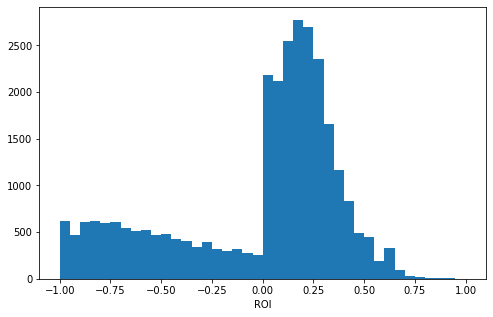

In [7]:
binsize = .05
bins = np.arange(-1.05, loans_to_2008['ROI'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'ROI', bins = bins)
plt.xlabel('ROI')
#plt.xticks(rotation)
plt.xlim(-1.1,1.1)
plt.show()

In [44]:
loans_to_2008.groupby('CreditScoreRangeLower').describe()

ListingNumber                                         \
                              count           mean            std      min   
CreditScoreRangeLower                                                        
0.0                           133.0   54269.368421   26943.939218   6736.0   
360.0                           1.0   34569.000000            NaN  34569.0   
420.0                           5.0   49535.800000   18873.350582  29250.0   
440.0                          36.0   58955.000000   25307.467615   6716.0   
460.0                         141.0   56926.581560   23769.648166  10325.0   
480.0                         346.0   55210.355491   25083.376792   8651.0   
500.0                         554.0   54088.151625   25662.578940   6819.0   
520.0                        1593.0  181717.533584  117764.465880   6666.0   
540.0                        1474.0  145434.482361  119215.328582   6597.0   
560.0                        1357.0  190494.660280  118269.912615   6606.0   
580.0                        1125.0  201091.905778  121307.257337   7121.0   
600.0                        2562.0  203180.919984  118936.103001   6660.0   
620.0                        2517.0  208537.984505  119012.382731   6596.0   
640.0                        3347.0  218569.140424  117032.727601   6588.0   
660.0                        2229.0  223635.048452  116376.522639   6570.0   
680.0                        2471.0  227422.657224  114356.225013   6775.0   
700.0                        1855.0  233070.997305  114282.511977   6537.0   
720.0                        1886.0  227505.906151  114800.490861   6550.0   
740.0                        1391.0  231040.831057  113559.467657   6877.0   
760.0                        1351.0  235411.143597  110846.308937   6888.0   
780.0                         919.0  229109.092492  115822.876556   7084.0   
800.0                         537.0  213280.368715  118098.308498   6958.0   
820.0                         366.0  228755.620219  120413.899740   6748.0   
840.0                         169.0  234669.514793  125105.505124  16972.0   
860.0                          90.0  189043.188889  117273.692598   8781.0   
880.0                          10.0  141975.800000   84115.583932  66637.0   

                                                                   Term  \
                             25%       50%        75%       max   count   
CreditScoreRangeLower                                                     
0.0                     27890.00   58741.0   78538.00   97950.0   133.0   
360.0                   34569.00   34569.0   34569.00   34569.0     1.0   
420.0                   29398.00   56923.0   64118.00   67990.0     5.0   
440.0                   44727.00   59377.0   80679.00   97349.0    36.0   
460.0                   37022.00   58535.0   77637.00   98239.0   141.0   
480.0                   31782.25   58627.0   76721.25   98212.0   346.0   
500.0                   29744.25   56613.0   76631.00   98166.0   554.0   
520.0                   87744.00  142104.0  290816.00  411855.0  1593.0   
540.0                   48033.50   98695.0  236614.50  410185.0  1474.0   
560.0                   89715.00  168128.0  292768.00  410773.0  1357.0   
580.0                   98311.00  189790.0  309970.00  410609.0  1125.0   
600.0                  101991.75  194603.0  314596.75  409908.0  2562.0   
620.0                  106383.00  204122.0  317421.00  412155.0  2517.0   
640.0                  118881.50  221597.0  324171.50  410843.0  3347.0   
660.0                  122093.00  231356.0  328454.00  414823.0  2229.0   
680.0                  130101.50  244129.0  329498.50  412589.0  2471.0   
700.0                  137520.50  252431.0  333475.00  413746.0  1855.0   
720.0                  128023.00  238779.5  327295.25  411814.0  1886.0   
740.0                  136211.00  247528.0  327632.00  410846.0  1391.0   
760.0                  139223.50  256641.0  329721.50  411495.0  1351.0   
780.0                  125604.00  

In [46]:
loans_to_2008.groupby('CreditScoreRangeLower').nunique()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewLoanStatus,ROI
CreditScoreRangeLower,,,,,,,,,,,,,,,,,,,,,
0.0,133,133,133,2,1,3,121,81,47,54,...,95,95,9,1,1,1,1,57,2,132
360.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
420.0,5,5,5,1,1,3,5,5,3,2,...,5,5,2,1,1,1,1,5,2,5
440.0,36,36,36,1,1,3,36,28,22,24,...,33,33,5,1,1,1,1,28,2,35
460.0,141,141,141,1,1,3,128,82,43,52,...,106,105,10,1,1,1,1,53,2,132
480.0,346,346,346,1,1,3,287,154,75,78,...,246,245,28,1,2,1,1,68,2,326
500.0,554,554,554,1,1,4,421,215,108,118,...,337,336,41,1,2,2,3,94,3,535
520.0,1593,1593,1593,1,1,4,981,554,298,322,...,897,891,149,1,6,5,63,137,3,1533
540.0,1474,1474,1474,2,1,3,962,530,307,318,...,762,754,138,1,4,4,55,163,2,1450


In [48]:
loans_to_2008.groupby('CreditScoreRangeUpper').nunique()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewLoanStatus,ROI
CreditScoreRangeUpper,,,,,,,,,,,,,,,,,,,,,
19.0,133,133,133,2,1,3,121,81,47,54,...,95,95,9,1,1,1,1,57,2,132
379.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
439.0,5,5,5,1,1,3,5,5,3,2,...,5,5,2,1,1,1,1,5,2,5
459.0,36,36,36,1,1,3,36,28,22,24,...,33,33,5,1,1,1,1,28,2,35
479.0,141,141,141,1,1,3,128,82,43,52,...,106,105,10,1,1,1,1,53,2,132
499.0,346,346,346,1,1,3,287,154,75,78,...,246,245,28,1,2,1,1,68,2,326
519.0,554,554,554,1,1,4,421,215,108,118,...,337,336,41,1,2,2,3,94,3,535
539.0,1593,1593,1593,1,1,4,981,554,298,322,...,897,891,149,1,6,5,63,137,3,1533
559.0,1474,1474,1474,2,1,3,962,530,307,318,...,762,754,138,1,4,4,55,163,2,1450


### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

My focus is on whether or not a loan was successful. 

I limited the loans to those begun on or prior to 2008, because I calculated that those loans should've been completed by well before the date that they stopped adding data to the dataframe. That way I can see what percentage of loans that should've been paid off were indeed paid off.

The variable of interest for this research is LoanStatus.

However, of the four categories of LoanStatus that occur in the data prior to 2009, two (ChargedOff and Defaulted) seem to me to be clearly unsuccessful, and one (Completed) as clearly successful. One (Cancelled) I am not sure how to assess, and there only five rows in the entire dataset with this outcome. Accordingly, I created a new variable NewLoanStatus with two categories: Successful for Completed and Unsuccessful for ChargedOff and Defaulted.

This is the breakdown for each category:

Completed - 18385 / Chargedoff - 6654 / Defaulted - 4012 / Cancelled - 5

Which results in:

Successful - 18,385 / Unsuccessful - 10664 / Total - 29,056

That's a success rate of 18385/29056 = 63%

I would've thought the success rate would be much higher than that.

How can a lender stay in business with this kind of a success rate?

The graph was of course straight-forward. There was no need for transformations.

But I wasn't sure that this was an adequate metric for analyzing the success of the loans. For one thing, these calculations don't account for how much money was recovered in the "Unsuccessful" loans. Both a loan that paid the principal and a small portion of the interest and a loan that didn't pay anything at all would be labelled "Unsuccessfull", but the former hypothetical loan is much more successful than the latter one.

So I decided to look at return on investment, calculated like this:

loans_to_2008['ROI'] = (loans_to_2008['LP_CustomerPayments'] - loans_to_2008['LoanOriginalAmount'] - loans_to_2008['LP_ServiceFees'] - loans_to_2008['LP_CollectionFees'] + loans_to_2008['LP_NonPrincipalRecoverypayments'])/loans_to_2008['LoanOriginalAmount'] 


With that metric, I saw that the bulk of the loans had an ROI between 0+ (a touch above 0)  and .3,and then tapered down to .75, with only a very few loans doing better than that on the positive side. The negative side had much less values, but they were much more uniform than the positive values. About 250 loans had an ROI of 0, and then the trend is a gradual slope upward until -1, where there are about 500 loans that I guess you could characterize as complete disasters (ie: an ROI of -1, and thus a loss of all the money lent).

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

Income Range: Nothing shocking here. By far the most loans went to people making between \\$25K and \\$50K; with the \\$50K to \\$75K range accounting for about 3/4 as many borrowers as the \\$25-\\$50K range, and the two groups of those making more and the one group of those making less than \\$25-\\$75k each accounting for about 1/4 as many loans as the \\$25-\\$50K group. So people with low to medium incomes accounted for the most loans, which isn't surprising. A lot of people fall into this category and their expenditures often drift beyond their incomes. The graph was straight forward. No transforamtions were needed.

Debt To Income: Values generally between 0 and 1. The best graph was at bin sizes of .02. Right skewed, concave to the right, convex to the left. A fairly long tail, but I didn't see a reason to do a log transformation -- the values (between 0 and 1.5) seemed too circumstribed for that. The highpoint was around .2, and there was a lot more variety to the values greater than .2 than to the values less than .2

Amount Delinquent: I did a log transformation since it had such a long tale. There was a fairly bell-shaped curve after the log transformation, with the bottom values close to zero and the top values around \\$100K. HOWEVER, to do a log transformation, I had to skip over those who were $0 delinquent, and they account for 2/3 of the total. Therefore, if I use this log transform in a presentation, I'd have to name it something like "Amount Delinquent (excluding those who owed \\$0)" and then prominently explain that they constitute the majority of the cases.

Credit Grade: Straight-forward graphs. At first, I was surprised at how many loans they gave to people with lower credit raitings. C was the most common rating, but D was almost as common as C, and there were a lot of loans given to people with even lower credit ratings. But then I decided that actually correlated well with the income range distribution: the better credit ratings probably went to the relatively few people at the higher income ranges.

Borrower State: Pretty straightforward graphs. I was surprised a little by the states that had the most borrowers. California had by far the most. That wasn't too surprising, since it is such a populous state. But the second most borrowers were in Georgia, and then Illinois. Those are large states, but Georgia particularly is nowhere near number 2 in population. I guess this has somethign to do with the states where Prosper had the largest presence during the time period we're analysing.

Occupation: I don't know how useful this one can be. By far the largest category is "Other" \\$7K+), and then the very vague "Professional" (\\$3K+). Then there are only three with at least \\$1K, and one of them is the still very vague "Clerical".

Home Owner: Straight forward. There's about 20% people who don't own homes than who do.

In [41]:
loans_to_2008.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29056 entries, 0 to 113927
Data columns (total 83 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   ListingKey                           29056 non-null  object        
 1   ListingNumber                        29056 non-null  int64         
 2   ListingCreationDate                  29056 non-null  datetime64[ns]
 3   CreditGrade                          28940 non-null  object        
 4   Term                                 29056 non-null  int64         
 5   LoanStatus                           29056 non-null  object        
 6   ClosedDate                           29056 non-null  object        
 7   BorrowerAPR                          29031 non-null  float64       
 8   BorrowerRate                         29056 non-null  float64       
 9   LenderYield                          29056 non-null  float64       
 10  Estimated

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

First I will organize the predictor variables by variable type.

In [7]:
numeric_vars = ['AmountDelinquent']
percent_vars = ['DebtToIncomeRatio']
ordinal_vars = ['CreditGrade', 'IncomeRange']
nominal_vars = ['BorrowerState', 'Occupation']
binary_vars = ['IsBorrowerHomeowner', 'EmploymentStatus']


### Debt to Income Ratio vs ROI

Text(0.5, 1.0, 'Debt to Income Ratio VS ROI')

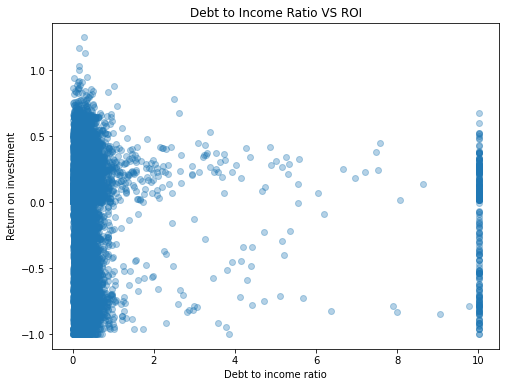

In [63]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'DebtToIncomeRatio', y = 'ROI', alpha=1/3)
plt.xlabel('Debt to income ratio')
plt.ylabel('Return on investment')
plt.title('Debt to Income Ratio VS ROI')


This tells me nothing. Most of the debt to income ratio's are less than one; and the most of those ROIs ranges from -1 to .75. The DTIR bump out past 1 from 0 to .5 and taper inward after that, shutting off around .75. It is a little surprising that higher ROIs seem to be correlated with slightly higher DTIR.

I will adjust the plot-points to see if I can see more info.

([<matplotlib.axis.XTick at 0x77fbd15968d0>,
 [Text(0.0, 0, '0'),
  Text(0.5, 0, '0.5'),
  Text(1.0, 0, '1'),
  Text(1.5, 0, '1.5'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(6.0, 0, '6'),
  Text(8.0, 0, '8'),
  Text(10.0, 0, '10')])

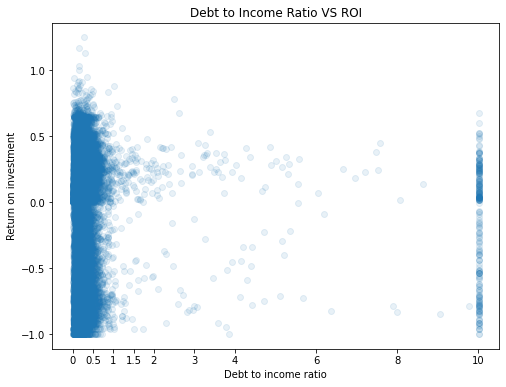

In [39]:
plt.figure(figsize = [8, 6])
xticks = [0,.5,1,1.5,2, 3, 4, 6, 8,10]
plt.scatter(data = loans_to_2008, x = 'DebtToIncomeRatio', y = 'ROI', alpha=1/10)
plt.xlabel('Debt to income ratio')
plt.ylabel('Return on investment')
plt.title('Debt to Income Ratio VS ROI')
plt.xticks(xticks, xticks)

Still pretty much a tower. The vast majority of the DTIR is between 0 and .75. You can see a little bulge outward (higher DtIs) as the ROIs start becoming postitive. That bump peaks at about 1 DTIR with a ROI of about .25, and then gradually sinks back to a DTI of about .75 at an ROI of .5, and holds steady with the DTIR though about .7 ROI

And everything else is an outlier.

I'll try once more, adding jitter.

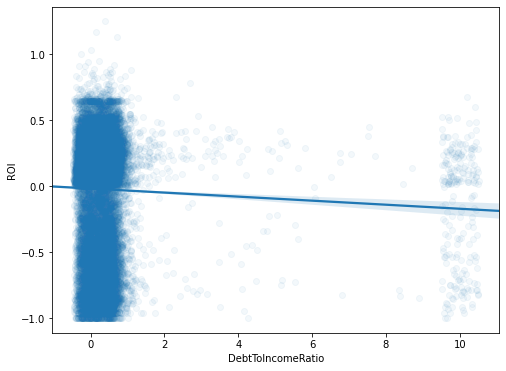

In [70]:
plt.figure(figsize = [8, 6])
sb.regplot(data = loans_to_2008, x = 'DebtToIncomeRatio', y = 'ROI', truncate=False, x_jitter=0.5, scatter_kws={'alpha':1/20});

Still not very interesting. Almost all DTIR values are within the same range, and they lead to the same results. It doesn't look like DTIR is a very good predictor value.

Let's run it through a correlation function.

In [40]:
roi_dtir = loans_to_2008[['DebtToIncomeRatio', 'ROI']].copy()
roi_dtir.corr(method='pearson')

,DebtToIncomeRatio,ROI
DebtToIncomeRatio,1.000000,-0.034124
ROI,-0.034124,1.000000


-.034 is not a very significant correlation.

I'll just check the pearson score after removing the outliers real quick and then stop investigating this variable.

In [9]:
less_than_3 = (loans_to_2008[loans_to_2008['DebtToIncomeRatio'] <3]).copy()

In [12]:
roi_dtir_2 = less_than_3[['DebtToIncomeRatio', 'ROI']].copy()

In [13]:
roi_dtir_2.corr(method='pearson')

,DebtToIncomeRatio,ROI
DebtToIncomeRatio,1.000000,-0.021871
ROI,-0.021871,1.000000


Still not a meaningful correlation.

In [62]:
dtir_10 = (loans_to_2008[loans_to_2008.DebtToIncomeRatio >= 9]).copy()
dtir_10.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewLoanStatus,ROI
226,2EA63382419173023274969,104542,2007-02-28 10:45:44.153,D,36,Completed,2009-07-07 00:00:00,0.11749,0.1000,0.0900,...,0.0,0.00,0.00,1.0,0,0,0.0,16,Successful,0.111060
576,3C18338635952151669AA4C,124494,2007-04-16 17:44:06.780,AA,36,Completed,2007-06-28 00:00:00,0.10505,0.0935,0.0885,...,0.0,0.00,0.00,1.0,0,0,0.0,58,Successful,0.016200
1242,029C3391969521662B80577,146341,2007-06-03 20:32:32.783,A,36,Completed,2010-05-25 00:00:00,0.11415,0.1072,0.0997,...,0.0,0.00,0.00,1.0,0,0,0.0,87,Successful,0.178200
1925,02F1339019841280370DC32,139992,2007-05-19 11:14:54.370,A,36,Defaulted,2010-09-29 00:00:00,0.08684,0.0800,0.0650,...,34.6,-34.34,32.62,1.0,1,1,750.0,19,Unsuccessful,0.144523
2217,7FF33379485792378896C12,91476,2007-01-31 14:16:07.313,C,36,Completed,2009-12-29 00:00:00,0.16436,0.1572,0.1472,...,0.0,0.00,0.00,1.0,0,0,0.0,179,Successful,0.240116


Text(0.5, 1.0, 'Debt to Income Ratio VS ROI')

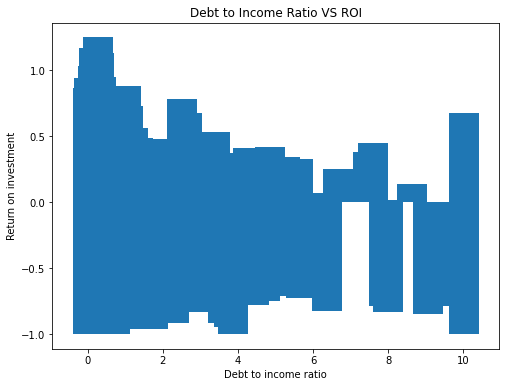

In [66]:
plt.figure(figsize = [8, 6])

plt.bar(data = loans_to_2008, x = 'DebtToIncomeRatio', height = 'ROI')
plt.xlabel('Debt to income ratio')
plt.ylabel('Return on investment')
plt.title('Debt to Income Ratio VS ROI')
#plt.ylim(-1.1, 1)

In [70]:
dtir = (loans_to_2008.groupby('DebtToIncomeRatio').mean()).copy()
dtir.ROI.head(40)

DebtToIncomeRatio
0.00000   -0.179402
0.00044    0.023433
0.00310   -0.974264
0.00611    0.122210
0.00647   -0.965610
0.00677    0.023290
0.00722    0.395710
0.01000    0.004224
0.01042   -0.839210
0.01051    0.000660
0.01087   -0.963565
0.01091   -0.030300
0.01115    0.102820
0.01138    0.242240
0.01234    0.031456
0.01275    0.140530
0.01289    0.017790
0.01303    0.023340
0.01315   -0.391612
0.01330    0.142610
0.01371   -0.757485
0.01404    0.000353
0.01459    0.173960
0.01482    0.055083
0.01504   -1.000000
0.01510    0.000440
0.01523    0.133968
0.01539   -0.545270
0.01544    0.423142
0.01581    0.153097
0.01609    0.128728
0.01663    0.125340
0.01719    0.004076
0.01747    0.011613
0.01783    0.004370
0.01784    0.328670
0.01825    0.072683
0.01853    0.242973
0.01876    0.069083
0.01877    0.434100
Name: ROI, dtype: float64

In [71]:
dtir.ROI.head()

DebtToIncomeRatio
0.00000   -0.179402
0.00044    0.023433
0.00310   -0.974264
0.00611    0.122210
0.00647   -0.965610
Name: ROI, dtype: float64

In [73]:
loans_to_2008.DebtToIncomeRatio.describe()

count    27799.000000
mean         0.323973
std          0.931787
min          0.000000
25%          0.120000
50%          0.200000
75%          0.300000
max         10.010000
Name: DebtToIncomeRatio, dtype: float64

In [75]:
# bins for debt to income ratio
# bin edges will be minimum, 25%, 50%, 75%, and max values
bin_edges = [0, .12, .2, .3, 10.01]
bin_names = ["LowDTIR", "MediumLowDTR", "MediumHighDTR", "HighDTR"]
# make a column of retweet levels
loans_to_2008["DTIRLevels"] = pd.cut(loans_to_2008['DebtToIncomeRatio'], bin_edges, labels=bin_names)
loans_to_2008.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewLoanStatus,ROI,DTIRLevels
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,0.00,0.00,1.0,0,0,0.0,258,Successful,0.223270,MediumLowDTR
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,0.00,0.00,1.0,0,0,0.0,41,Successful,0.403142,LowDTIR
11,0F1734025150298088A5F2B,213551,2007-10-09 20:28:33.640,C,36,Completed,2008-01-07 00:00:00,0.15033,0.1325,0.1225,...,0.00,0.00,1.0,0,0,0.0,53,Successful,0.012530,MediumHighDTR
17,0FDF336575182398852A8DC,31540,2006-08-15 12:21:09.433,AA,36,Chargedoff,2008-05-22 00:00:00,0.13202,0.1250,0.1175,...,6012.67,268.96,1.0,0,0,0.0,85,Unsuccessful,-0.435110,LowDTIR
21,1017340630713945364DA6B,241498,2007-11-30 20:33:49.227,D,36,Completed,2010-12-12 00:00:00,0.21488,0.2075,0.1975,...,0.00,0.00,1.0,0,0,0.0,53,Successful,0.370723,LowDTIR


In [76]:
dtir_levels = (loans_to_2008.groupby('DTIRLevels').mean()).copy()

In [77]:
dtir_levels.ROI

DTIRLevels
LowDTIR         -0.024026
MediumLowDTR    -0.009126
MediumHighDTR   -0.013603
HighDTR         -0.043563
Name: ROI, dtype: float64

### Amount Delinquent vs ROI

Text(0.5, 1.0, 'Amount Delinquent VS ROI')

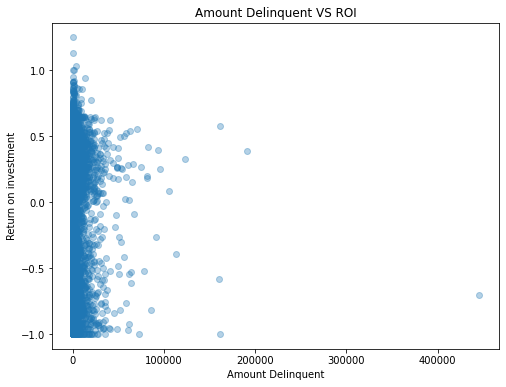

In [41]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'AmountDelinquent', y = 'ROI', alpha=1/3)
plt.xlabel('Amount Delinquent')
plt.ylabel('Return on investment')
plt.title('Amount Delinquent VS ROI')

(-1.0, 50000.0)

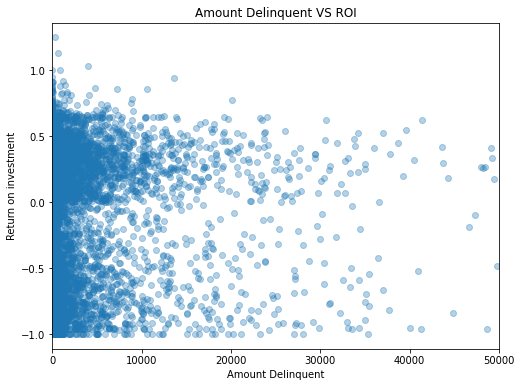

In [25]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'AmountDelinquent', y = 'ROI', alpha=1/3)
plt.xlabel('Amount Delinquent')
plt.ylabel('Return on investment')
plt.title('Amount Delinquent VS ROI')
plt.xlim(-1, 50000)

This also doesn't look like a very useful metric. I'll run it through the correlation function real quick.

In [43]:
ad_roi = loans_to_2008[['AmountDelinquent', 'ROI']].copy()
ad_roi.corr(method='pearson')

,AmountDelinquent,ROI
AmountDelinquent,1.000000,-0.041555
ROI,-0.041555,1.000000


This isn't a significant correlation. A small pearson correlation is from |.1| to |.3|

This isn't even very close to |.1|

Let's just see what happens if we remove the outliers.

In [14]:
ad_lt20 = loans_to_2008[loans_to_2008['AmountDelinquent'] < 20000].copy()
adlt20_roi = ad_lt20[['AmountDelinquent', 'ROI']].copy()
adlt20_roi.corr(method='pearson')

,AmountDelinquent,ROI
AmountDelinquent,1.00000,-0.04486
ROI,-0.04486,1.00000


Still not even a small correlation.

### Ordinal Variables: Credit Grade & Income Range

Now I'll look at the two ordinal variables. CreditGrade & IncomeRange

First I'll see how they relate to each other.

Then I'll compare them to ROI.

In [8]:
# as an exercise, I'll turn these ordinal variables into categories computationally.

# convert CreditGrade and IncomeRange into ordered categorical types
ordinal_var_dict = {'CreditGrade': ['AA', 'A', 'B', 'C', 'D', 'E', 'HR','NC'],
                    'IncomeRange': ['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+','Not employed', 'Not displayed'],
                   'CreditScoreRangeUpper': ['19.0', '379.0', '439.0', '459.0', '479.0', '499.0', '519.0', '539.0', '559.0', '579.0', '599.0', '619.0', '639.0','659.0', '679.0', '699.0', '719.0', '739.0', '759.0', '779.0', '799.0', '819.0', '839.0', '859.0', '879.0', '899.0', 'nan']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    loans_to_2008[var] = loans_to_2008[var].astype(ordered_var)

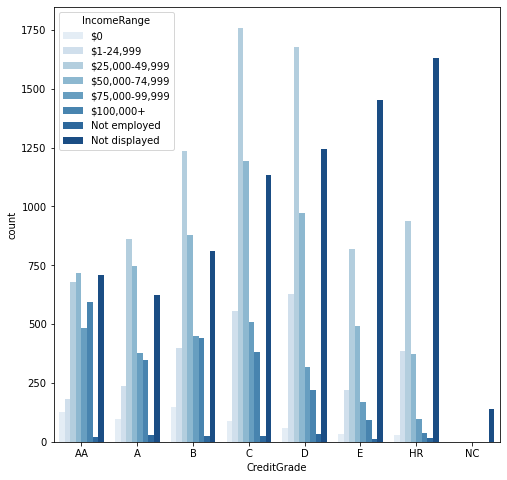

In [45]:

plt.figure(figsize = [8, 8])

# subplot 1: CreditGrade vs IncomeRange

sb.countplot(data = loans_to_2008, x = 'CreditGrade', hue = 'IncomeRange', palette = 'Blues')
plt.show()

I think this would be more meaningful if I had the percent of each income range in each credit rating.

I'll try a barplot. But that won't work if both variables are categorical. I'll try StatedMonthlyIncome instead.

<AxesSubplot:xlabel='CreditGrade', ylabel='StatedMonthlyIncome'>

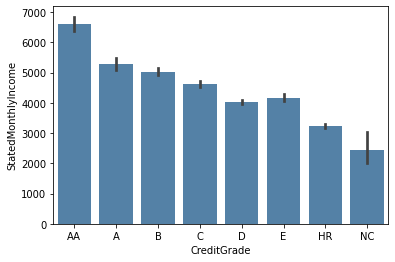

In [77]:
sb.barplot(x="CreditGrade", y="StatedMonthlyIncome", color='steelblue', data=loans_to_2008)

That makes sense. For AA, the incomes are quite a bit higher than the rest. Then from A to B and C there is a gradual slope, dropping off more for C to D. And then for some reason a little bit up for E.

I should check to see how StatedMonthlyIncome relates to IncomeRange.

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '$0'),
  Text(1, 0, '$1-24,999'),
  Text(2, 0, '$25,000-49,999'),
  Text(3, 0, '$50,000-74,999'),
  Text(4, 0, '$75,000-99,999'),
  Text(5, 0, '$100,000+'),
  Text(6, 0, 'Not employed'),
  Text(7, 0, 'Not displayed')])

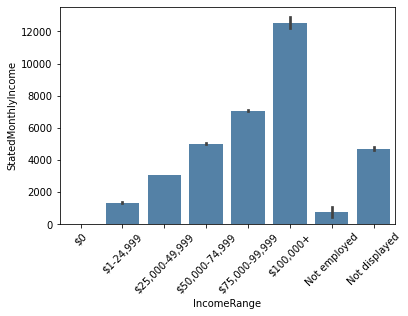

In [78]:
sb.barplot(x="IncomeRange", y="StatedMonthlyIncome", color='steelblue', data=loans_to_2008)
plt.xticks(rotation=45)

Correlated very linearly up through the \\$ 75&ndash; \\$99,9999 range.

The more drastic slope from that category up to the \\$100K+ category is also predictable -- because of the + at the end of the \\$100.

So we should be able to use IncomeRange and StatedMonthlyIncome interchangeably.

Let's compare ROI with these CreditRange, IncomeRange, and StatedMonthlyIncome.

### CreditGrade vs ROI and IncomeRange vs ROI

## Move the below or delete

/home/werdnamac/.local/lib/python3.7/site-packages/seaborn/axisgrid.py:1209: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
/home/werdnamac/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/werdnamac/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/werdnamac/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword a

<Figure size 720x720 with 0 Axes>

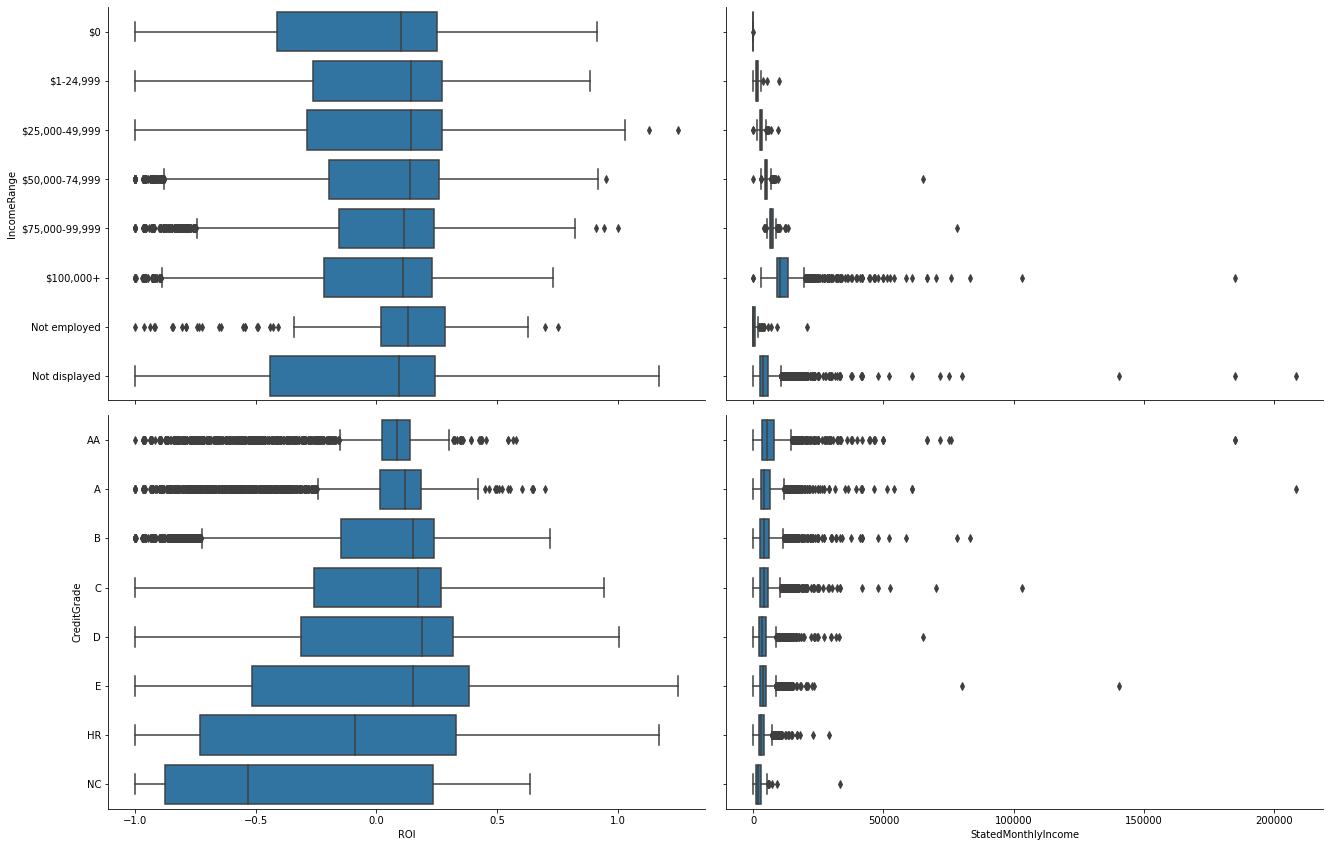

In [80]:
ordinal_vars = ['IncomeRange', 'CreditGrade']
def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = default_color)

plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = loans_to_2008, x_vars = ['ROI', 'StatedMonthlyIncome'], y_vars = ordinal_vars,
                size = 6, aspect = 1.5)
g.map(boxgrid)
#plt.xticks(rotation=)
plt.show();

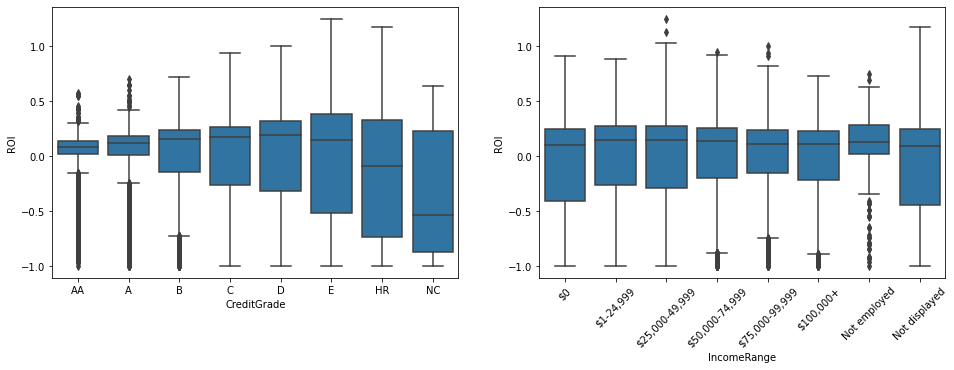

In [90]:
#  TWO PLOTS IN ONE FIGURE
plt.figure(figsize = [16, 5])
base_color = sb.color_palette()[0]

# LEFT plot: credit grade vs roi
plt.subplot(1, 2, 1)
sb.boxplot(data=loans_to_2008, x='CreditGrade', y='ROI', color=base_color);


# RIGHT plot: box plot
plt.subplot(1, 2, 2)
sb.boxplot(data=loans_to_2008, x='IncomeRange', y='ROI', color=base_color)
plt.xticks(rotation=45);


The mean ROIs look positive for all Credit Grades (except HR, which I don't know the definition of; and NC, which means there's no credit rating).

Interestingly, the mean ROI is a little better at As than AAs, and at Bs than As, and at Cs than Bs, and at Ds than Cs. It drops down again at credit ratings of Es. I imagine this has to do with the terms available at the various ranges. AAs get the best borrowing rates and so the returns are the narrowest, but (judging by the bottom and top 75% range), there's less variety in outcomes. As you go down in credit ratings, the lower 75% range gets lower and lower, but the loan terms must favor the lender to such a degree that on the whole, they still come out ahead -- indeed, beating their margin for error (ie: ending up with an average ROI even higher than the AAs average ROI) in all categories except E. 

From this, it looks like Credit Grade is a very reliable metric -- lending agencies can use them to ensure that (in the aggregate) they make a profit (barring disasters, and apparently even including pretty serious ones -- this data is for loans originating between 2005 and 2008 and The Great Recession was from 2007 to 2009). If all these box plots had the same means and the same interquartiles, we would conclude that they were not a very useful metric. But since the bottom quartiles correlate so well to the grades (lower bottom quartiles as grades decrease), it seems clear that the credit grades are providing useful information about loan outcomes that the lenders use set lending rates that guarantee that on average they come out ahead.

However, this makes me wonder if ROI is the best measure of a loan's success after all. Since (at least for important predictors like Credit Grade that Prosper would rely on to set their terms) what I'm really discovering with the ROI metric is how well Prosper uses the various predictors to choose their loan terms. I think I will therefore have a look at how Credit Grade and Income Range relate to my original Successful/Unsuccessful metric.

All income ranges also correlate to pretty similar mean outcomes (around 10% returns), suggesting that this data also correlates well to successful loan-setting policies from Prosper. And again the boxes tend to shrink as the borrowers finances get better, indicating safer bets. Although, the over \\$100K group has a lower bottom quartile than the \\$75K-\\$99K group. And the Not Employed group somehow appear to be among the safest bets (perhaps because they have to provide other compelling reasons to get a loan?).

Let's look at CreditGrade and Income Ranges vs ROI on violin plots.

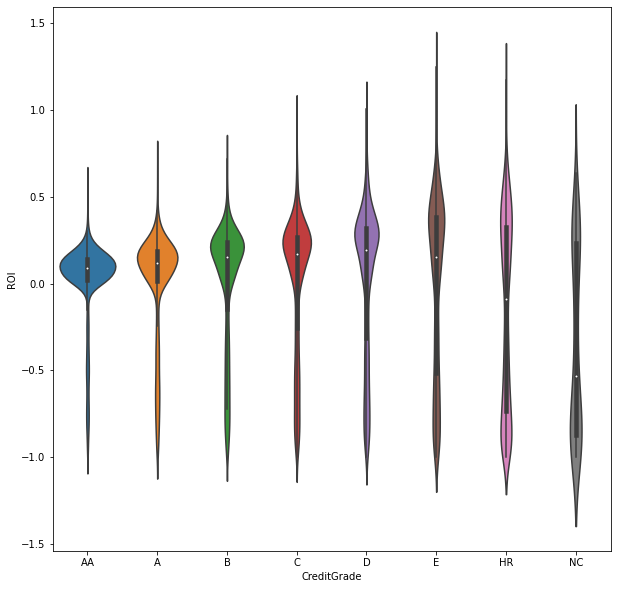

In [76]:
plt.figure(figsize = [10,10])
sb.violinplot(data=loans_to_2008, x='CreditGrade', y='ROI');

As credit grade goes down, the tendency is to get more variety in the outcomes. The mean ROI holds pretty steady(around 10%), but there's a lot more indivual loans with negative ROIs. These are offset by more indivual loans with higher ROIs. I imagine this is because they charge people with lower credit grades higher interest rates. So, when they collect all the money in the original loan term, they make a larger profit.

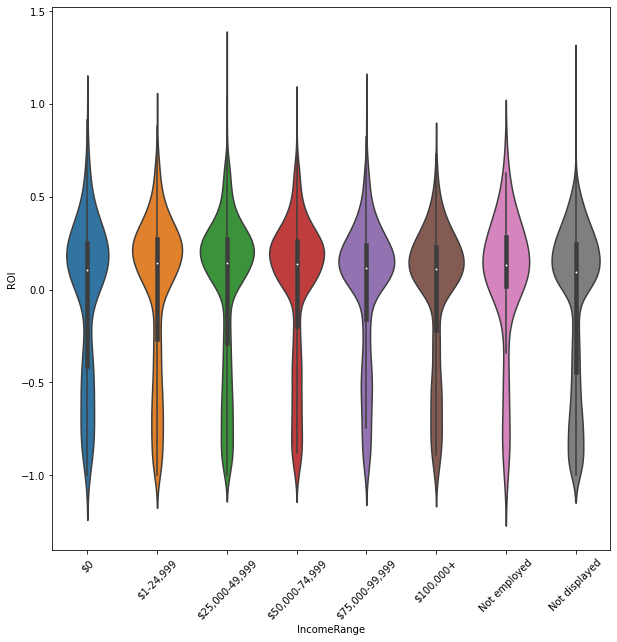

In [45]:
plt.figure(figsize = [10,10])
sb.violinplot(data=loans_to_2008, x='IncomeRange', y='ROI')
plt.xticks(rotation=45);

There doesn't seem to be much difference in ROI at different income ranges. The plots do get a little wider at the higher ranges -- suggesting that more loans are closer to the median (a symptom of less risk loans: more loans turn out the way you predicted they would, which I guess is around a 10% return (since all the means are around 10% and I imagine that has to do with charging higher interest rates to riskier loans)). 

Why don't the Credit Rating and Income Range violin plots look more alike? I guess because with more data than just a borrower's income range, Prosper makes better guesses about the loan outcomes and is better at predicting who they should lend to and how much they should charge them -- this makes the plots correspond better to Credit Grade than Income Range.

Before proceeding, I'd like to see how my two possible primary metric -- ROI and Succesful/Unsuccessful relate to each other.

#### NewLoanStatus vs ROI

In [15]:
ns_roi = (loans_to_2008.groupby('NewLoanStatus').ROI.mean()).copy()
ns_roi

NewLoanStatus
Cancelled      -1.000000
Successful      0.226617
Unsuccessful   -0.454085
Name: ROI, dtype: float64

<AxesSubplot:xlabel='NewLoanStatus'>

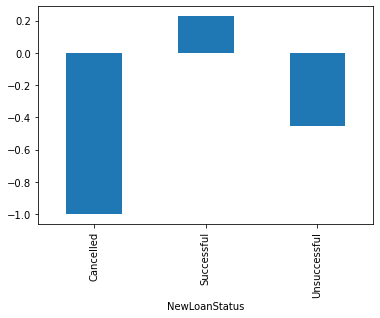

In [16]:
ns_roi.plot.bar()

<AxesSubplot:xlabel='NewLoanStatus'>

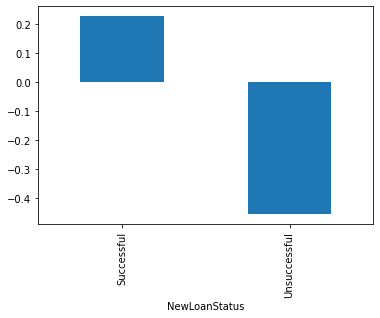

In [23]:
# there's only 5 cancelled loans in the data set, so let's just get rid of them
nocan = (loans_to_2008[loans_to_2008['NewLoanStatus'] != 'Cancelled']).copy()
nocan = nocan.groupby('NewLoanStatus').ROI.mean()
nocan.plot.bar()

This seems to be a fairly significant correlation. On average, the Successful loans have a 20% return and the Unsuccessful ones have a -40% return. Maybe my original primary metric was OK, after all. But ROI still seems better, as it gives more details about the loan outcomes.

### CreditGrade vs NewLoanStatus & IncomeRange vs NewLoanStatus

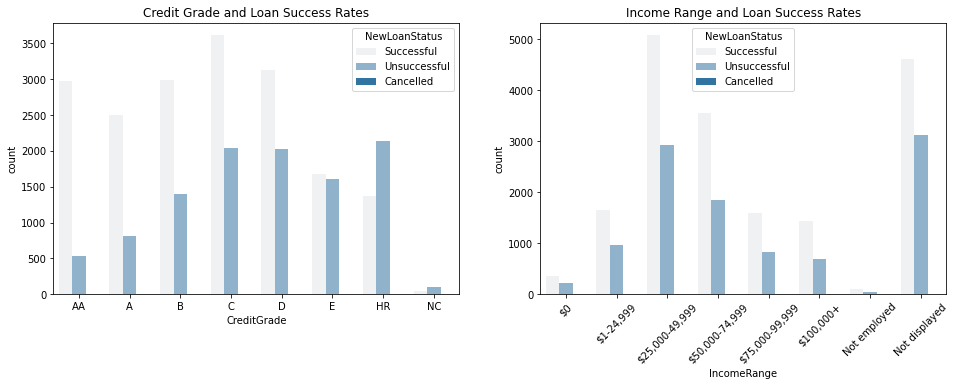

In [27]:
#  TWO PLOTS IN ONE FIGURE
plt.figure(figsize = [16, 5])
base_color = sb.color_palette()[0]

# LEFT plot: credit grade vs NewLoanStatus (Successful/Unsuccessful)
plt.subplot(1, 2, 1)
sb.countplot(data=loans_to_2008, x='CreditGrade', hue='NewLoanStatus', color=base_color);
plt.title('Credit Grade and Loan Success Rates')


# RIGHT plot: box plot
plt.subplot(1, 2, 2)
sb.countplot(data=loans_to_2008, x='IncomeRange', hue='NewLoanStatus', color=base_color)
plt.title('Income Range and Loan Success Rates')
plt.xticks(rotation=45);

For Credit Grade, the Unsuccessful loans increase pretty linearly from AA to A to B to C. The AA Successful loans are quite a bit higher than the A; but the Successful loans progress pretty linearly from A to B to C. 

Similar trends can be found in the medium three income ranges. 

I think this data would be more useful if the Successful and Unsuccesful loans were measured as percentages of the total loans for each Credit Grade or Income Range. 

In [28]:
# make a new data frame that makes the NewLoanStatus column numeric

numeric_status = loans_to_2008.copy()
dict_map = dict(zip(['Successful', 'Unsuccessful', 'Cancelled'], [1, 0, 0]))

numeric_status['NewLoanStatus'] = loans_to_2008['NewLoanStatus'].map(dict_map)
numeric_status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29056 entries, 0 to 113927
Data columns (total 83 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   ListingKey                           29056 non-null  object        
 1   ListingNumber                        29056 non-null  int64         
 2   ListingCreationDate                  29056 non-null  datetime64[ns]
 3   CreditGrade                          28940 non-null  category      
 4   Term                                 29056 non-null  int64         
 5   LoanStatus                           29056 non-null  object        
 6   ClosedDate                           29056 non-null  object        
 7   BorrowerAPR                          29031 non-null  float64       
 8   BorrowerRate                         29056 non-null  float64       
 9   LenderYield                          29056 non-null  float64       
 10  Estimated

In [32]:
# group the credit grades together and find the average values for all columns

cg_percentages = numeric_status.groupby('CreditGrade').mean()
cg_percentages.head()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewLoanStatus,ROI
CreditGrade,,,,,,,,,,,,,,,,,,,,,
AA,221389.092645,36.0,0.106188,0.098066,0.092331,NaN,NaN,NaN,NaN,NaN,...,1433.558766,1387.638756,39.524615,1.000000,0.192987,0.113740,55.064795,188.133124,0.846066,0.018847
A,222908.348023,36.0,0.135710,0.125107,0.116858,NaN,NaN,NaN,NaN,NaN,...,2046.325548,1983.434805,74.910024,1.000003,0.136432,0.071235,47.106414,186.782372,0.755810,-0.000372
B,225470.874373,36.0,0.164317,0.153568,0.143226,NaN,NaN,NaN,NaN,NaN,...,2224.422843,2150.458753,102.168263,1.000000,0.140903,0.067715,47.864291,168.337209,0.680347,-0.006543
C,216176.860028,36.0,0.193434,0.179668,0.169059,NaN,NaN,NaN,NaN,NaN,...,1794.225698,1736.129667,91.301770,1.000000,0.126683,0.051914,43.761217,112.031184,0.638909,-0.004018
D,202643.606290,36.0,0.225463,0.211864,0.201086,NaN,NaN,NaN,NaN,NaN,...,1456.824021,1418.683487,74.046653,1.000000,0.135702,0.064648,60.368074,84.676374,0.606484,0.010531


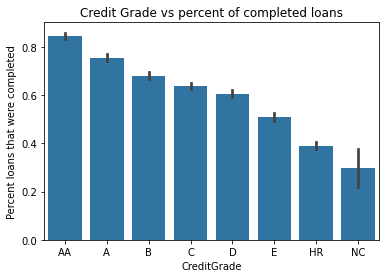

In [33]:
# create a graph of credit grade verus percent successful

sb.barplot(data=numeric_status, x='CreditGrade', y='NewLoanStatus', color=base_color)
plt.title('Credit Grade vs percent of completed loans')
plt.ylabel('Percent loans that were completed');

That shows a fairly clear correlation.

I'll try the same with Income Ranges

In [34]:
# group by income range together and find the average values for all columns

ir_percentages = numeric_status.groupby('IncomeRange').mean()
ir_percentages.head()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewLoanStatus,ROI
IncomeRange,,,,,,,,,,,,,,,,,,,,,
$0,281325.385417,36.000000,0.203395,0.189685,0.180276,NaN,NaN,NaN,NaN,NaN,...,2678.350920,2633.086302,78.380000,1.0,0.428819,0.312500,321.902083,115.057292,0.611111,-0.044269
"$1-24,999",252019.864731,36.000000,0.205540,0.190458,0.179201,NaN,NaN,NaN,NaN,NaN,...,1166.728280,1121.210222,55.140951,1.0,0.207107,0.096676,78.219606,82.332442,0.633550,-0.003285
"$25,000-49,999",255652.079920,35.997003,0.202081,0.187482,0.176408,NaN,NaN,NaN,NaN,NaN,...,1404.701505,1357.476025,68.040249,1.0,0.187063,0.087787,63.214170,112.253996,0.633741,-0.007522
"$50,000-74,999",258727.784738,36.000000,0.193267,0.179642,0.169176,NaN,NaN,NaN,NaN,NaN,...,1722.581789,1663.684551,106.791160,1.0,0.164634,0.081301,59.250078,143.195492,0.657243,0.006745
"$75,000-99,999",258692.036409,36.000000,0.180352,0.167715,0.157874,NaN,NaN,NaN,NaN,NaN,...,2159.522664,2068.324688,122.833438,1.0,0.155565,0.079851,51.334175,173.000827,0.658254,0.000262


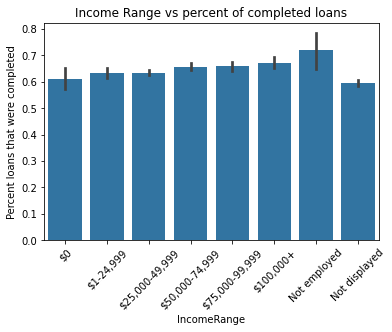

In [35]:
# create a graph of credit grade verus percent successful

sb.barplot(data=numeric_status, x='IncomeRange', y='NewLoanStatus', color=base_color)
plt.title('Income Range vs percent of completed loans')
plt.ylabel('Percent loans that were completed')
plt.xticks(rotation=45);

60% success rate for \\$0 income. Something like 62% for the newt two ranges. And then up to maybe 65% for both the \\$50K-\\$74K and the \\$75K-\\$99K ranges. And then up another percentage point or so for the highest income range. That's a trend, although not as strong as I would've predicted. And why would the unemployed be the best at paying off their loans??

I didn't end up using the groupby-ed data frames for those two graphs. But while I'm here I think I will use those data frames to look at the relationship between ROI and both Credit Grade and Income Ranges

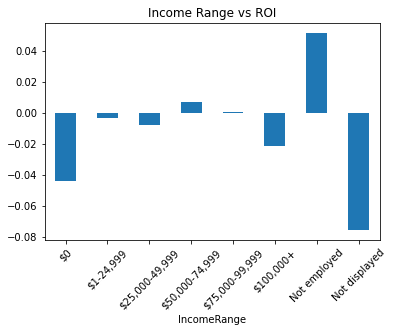

In [39]:
ir_perc_roi = (ir_percentages.ROI).copy()

ir_perc_roi.plot.bar()
plt.title('Income Range vs ROI')
plt.xticks(rotation=45);

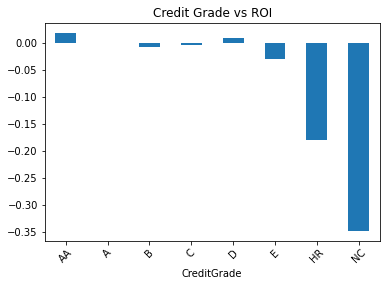

In [40]:
cg_perc_roi = (cg_percentages.ROI).copy()

cg_perc_roi.plot.bar()
plt.title('Credit Grade vs ROI')
plt.xticks(rotation=45);

This does not agree with the box plots I drew earlier. Those had a positive mean ROI for the \\$100K+ group.

In [41]:
### Probably delete this

/home/werdnamac/.local/lib/python3.7/site-packages/seaborn/axisgrid.py:1209: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
/home/werdnamac/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/werdnamac/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/werdnamac/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword a

<Figure size 720x720 with 0 Axes>

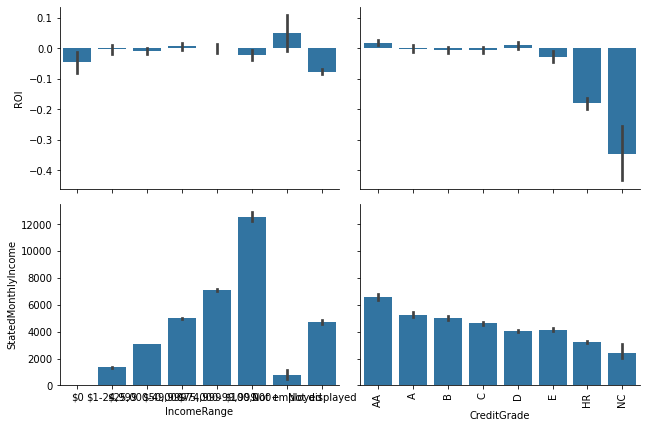

In [8]:
ordinal_vars = ['IncomeRange', 'CreditGrade']
def bargrid(x, y, **kwargs):
    """ Quick hack for creating bar plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0]
    sb.barplot(x, y, color = default_color)

plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = loans_to_2008, y_vars = ['ROI', 'StatedMonthlyIncome'], x_vars = ordinal_vars,
                size = 3, aspect = 1.5)
g.map(bargrid)
plt.xticks(rotation=90)
#plt.title('ROI vs Stated Monthly Income')
#plt.ylabel('StatedMonthlyIncome');
plt.show();

<AxesSubplot:xlabel='CreditGrade', ylabel='ROI'>

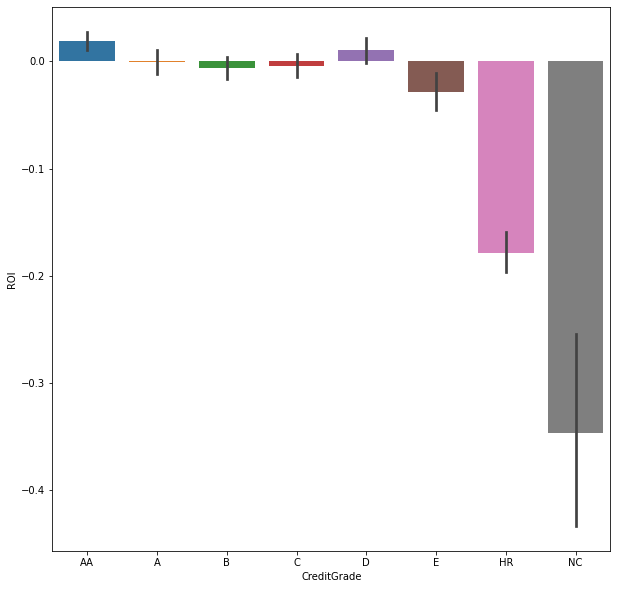

In [75]:

plt.figure(figsize = [10,10])
sb.barplot(x="CreditGrade", y="ROI", data=loans_to_2008)

### StatedMonthlyIncome vs ROI

Text(0.5, 1.0, 'Stated Monthly Income VS ROI')

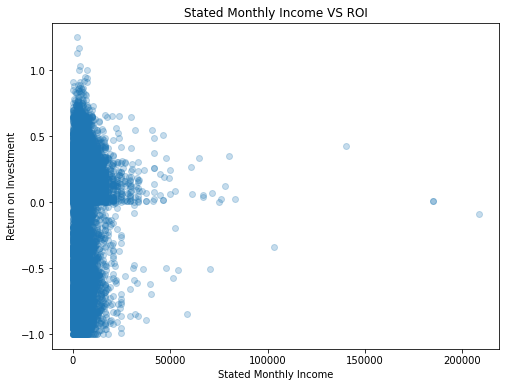

In [60]:
plt.figure(figsize = [8, 6])
#xticks = [100,500,1000,,2, 3, 4, 6, 8,10]
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y = 'ROI', alpha=1/4)
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI')
#plt.xticks(xticks, xticks)

There's some crazy outliers.
First I'll see what happens if we zoom in to the bulk of the data.

(0.0, 50000.0)

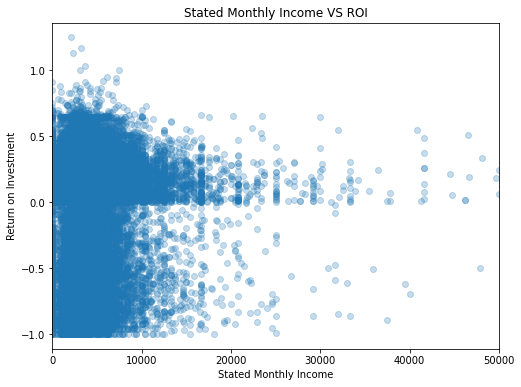

In [64]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y = 'ROI', alpha=1/4)
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI')
plt.xlim(-0, 50000)

Past 25,000 there are proportionately very few values.

Let's see what happens if we zoom in further.

(0.0, 25000.0)

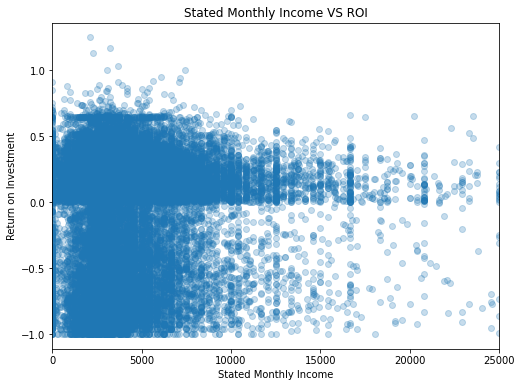

In [65]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y = 'ROI', alpha=1/4)
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI')
plt.xlim(-0, 25000) 

(0.0, 20000.0)

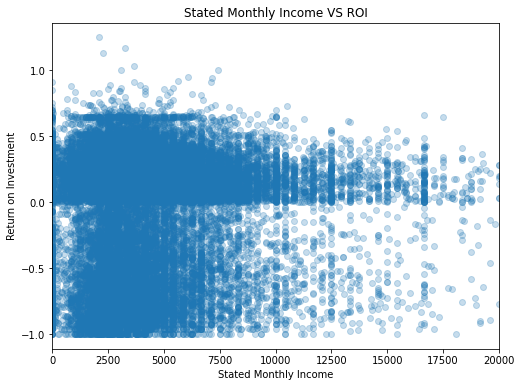

In [66]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y = 'ROI', alpha=1/4)
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI')
plt.xlim(-0, 20000) 

(0.0, 15000.0)

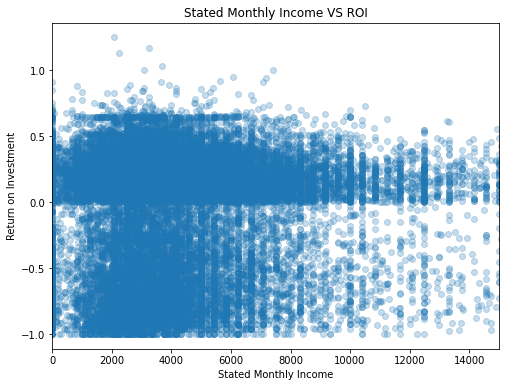

In [67]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y = 'ROI', alpha=1/4)
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI')
plt.xlim(-0, 15000) 

(0.0, 10000.0)

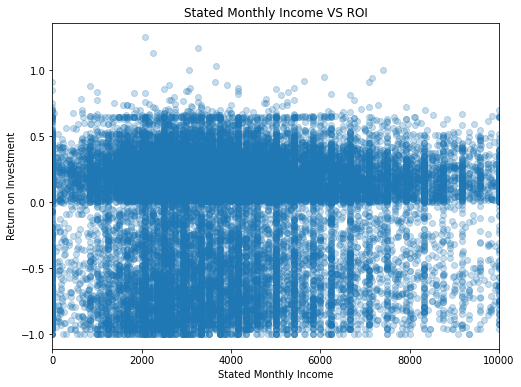

In [49]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y = 'ROI', alpha=1/4)
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI')
plt.xlim(0, 10000) 

(0.0, 6000.0)

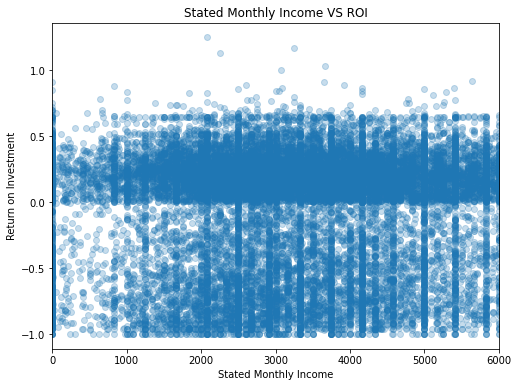

In [69]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y = 'ROI', alpha=1/4)
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI')
plt.xlim(-0, 6000) 

Zooming in seems to make the trend I initially noticed -- a little downward slope in ROIs as incomes go up -- disappear. Let's try a log tansformation.

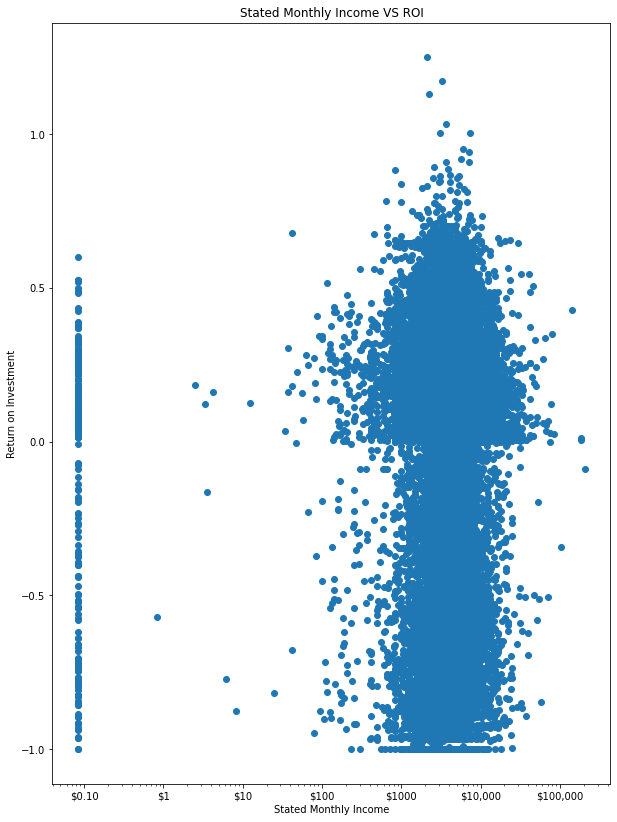

In [12]:
plt.figure(figsize=[10, 14])
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y='ROI')
plt.xscale('log')
plt.xticks([.10, 1, 10, 100, 1000, 10000, 100000], ['$0.10', '$1', '$10', '$100', '$1000', '$10,000', '$100,000'])
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI')
plt.show()

There seems to be a trend -- the ROIs increase as we go up from a couple hundred to thousands of dollars a month; and then start sloping down again a little before \\$10K a month.

Let's see what Pearson says.

In [29]:
monthly_roi = (loans_to_2008[['StatedMonthlyIncome', 'ROI']]).copy()
monthly_roi.head()

,StatedMonthlyIncome,ROI
0,3083.333333,0.223270
2,2083.333333,0.403142
11,1666.666667,0.012530
17,5833.333333,-0.435110
21,3750.000000,0.370723


In [30]:
monthly_roi.corr(method='pearson')

,StatedMonthlyIncome,ROI
StatedMonthlyIncome,1.000000,0.021878
ROI,0.021878,1.000000


According to Pearson, Stated Montly Income is not a good predictor of ROI.

What would happen if we do a Pearson evaluation on the section with most of the data -- from say \\$300 to \\$30,000 a month?

In [14]:
typical_incomes = (loans_to_2008[(loans_to_2008['StatedMonthlyIncome'] <= 30000) & (loans_to_2008['StatedMonthlyIncome'] >= 300)]).copy()
typinc_roi = (typical_incomes[['StatedMonthlyIncome', 'ROI']]).copy()
typinc_roi.head()

,StatedMonthlyIncome,ROI
0,3083.333333,0.223270
2,2083.333333,0.403142
11,1666.666667,0.012530
17,5833.333333,-0.435110
21,3750.000000,0.370723


In [15]:
typinc_roi.corr(method='pearson')

,StatedMonthlyIncome,ROI
StatedMonthlyIncome,1.000000,0.024479
ROI,0.024479,1.000000


Still not a significant correlation.

I am disappointed that so far of the possible predictor variables I studied, only Credit Grade is looking like a very good predictor. So I will add in the CreditScoreRangeUpper, which I believe must be correlated with outcomes. (CreditScoreRangeLower should be too. I have no particular reason for choosing Upper over Lower.)

Text(0.5, 1.0, 'Credit Range VS ROI')

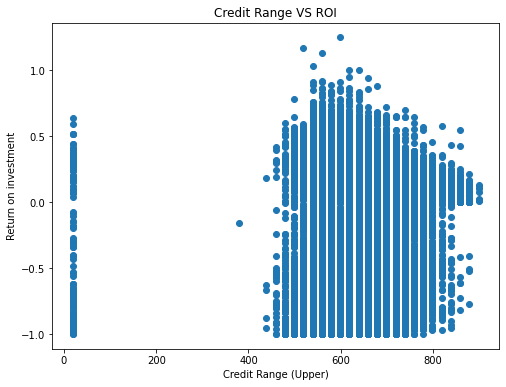

In [10]:
# try a scatter plot
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'CreditScoreRangeUpper', y = 'ROI')
plt.xlabel('Credit Range (Upper)')
plt.ylabel('Return on investment')
plt.title('Credit Range VS ROI')
#plt.xlim(0,1000)

Text(0.5, 1.0, 'Credit Range VS ROI')

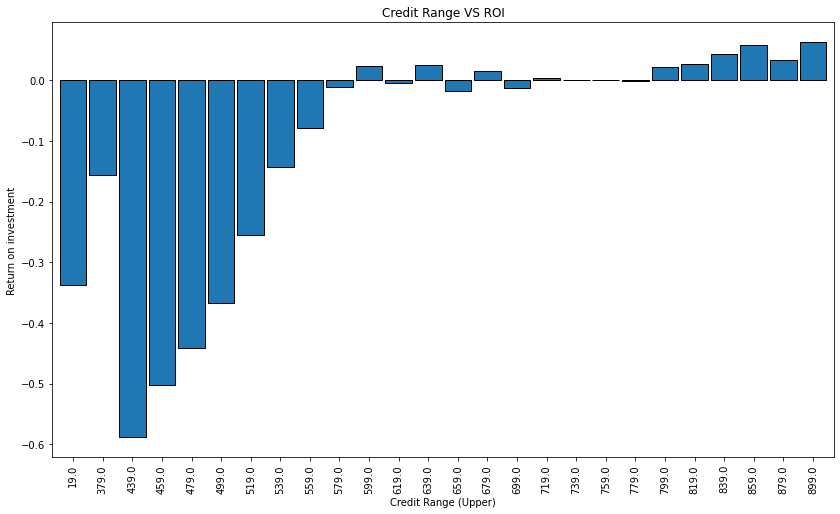

In [14]:
# now a bar with groupby

loans_to_2008[['CreditScoreRangeUpper', 'ROI']].groupby('CreditScoreRangeUpper').ROI.mean().plot.bar(edgecolor='black', figsize=[14,8], width=.9);
plt.xlabel('Credit Score Range (Upper)')
plt.ylabel('Return on investment')
plt.title('Credit Range VS ROI')

The middle Credit Ranges show mixed results; the lower scores are uniformly negative average ROIs. Only up around upper credit ranges of about 800 does Prosper start to turn a solid profit. Why do they ever lend to anyone below a 579 credit rating? Below that even their average ROI is consistently a loss of 10% or more.

Let's go over Credit Range versus StatedMonthlyIncome and versus Income Range

Text(0.5, 1.0, 'Credit Range VS SMI')

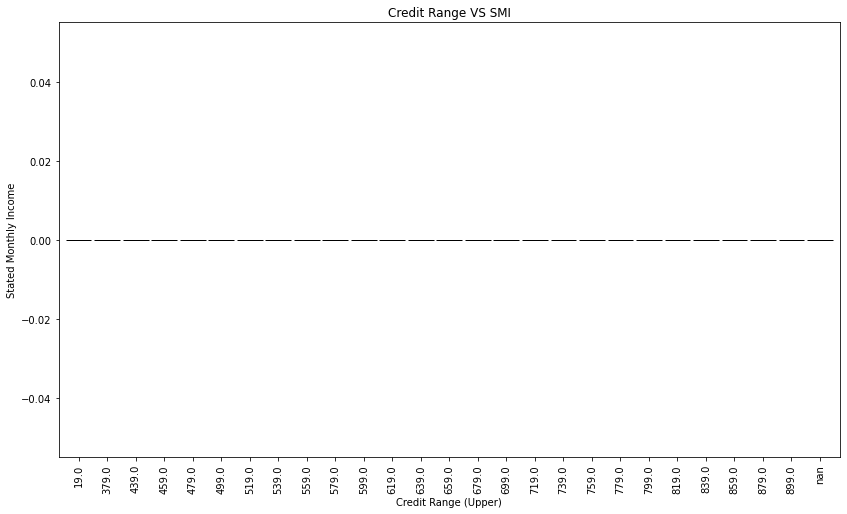

In [23]:
loans_to_2008[['CreditScoreRangeUpper', 'StatedMonthlyIncome']].groupby('CreditScoreRangeUpper').StatedMonthlyIncome.mean().plot.bar(edgecolor='black', figsize=[14,8], width=.9);
plt.xlabel('Credit Range (Upper)')
plt.ylabel('Stated Monthly Income')
plt.title('Credit Range VS SMI')

Text(0.5, 1.0, 'Credit Range VS Stated Monthly Income')

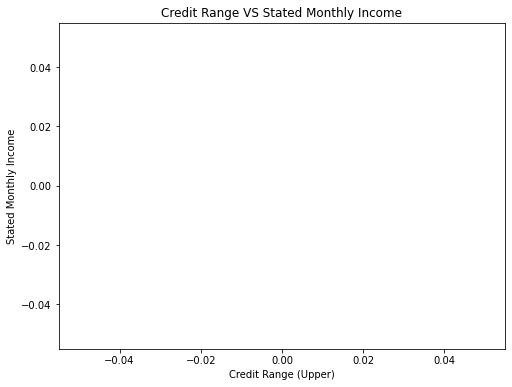

In [24]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'CreditScoreRangeUpper', y = 'StatedMonthlyIncome')
plt.xlabel('Credit Range (Upper)')
plt.ylabel('Stated Monthly Income')
plt.title('Credit Range VS Stated Monthly Income')
#plt.xlim(0,1000)

#### Credit Grade vs Credit Score Range (Upper & Lower)

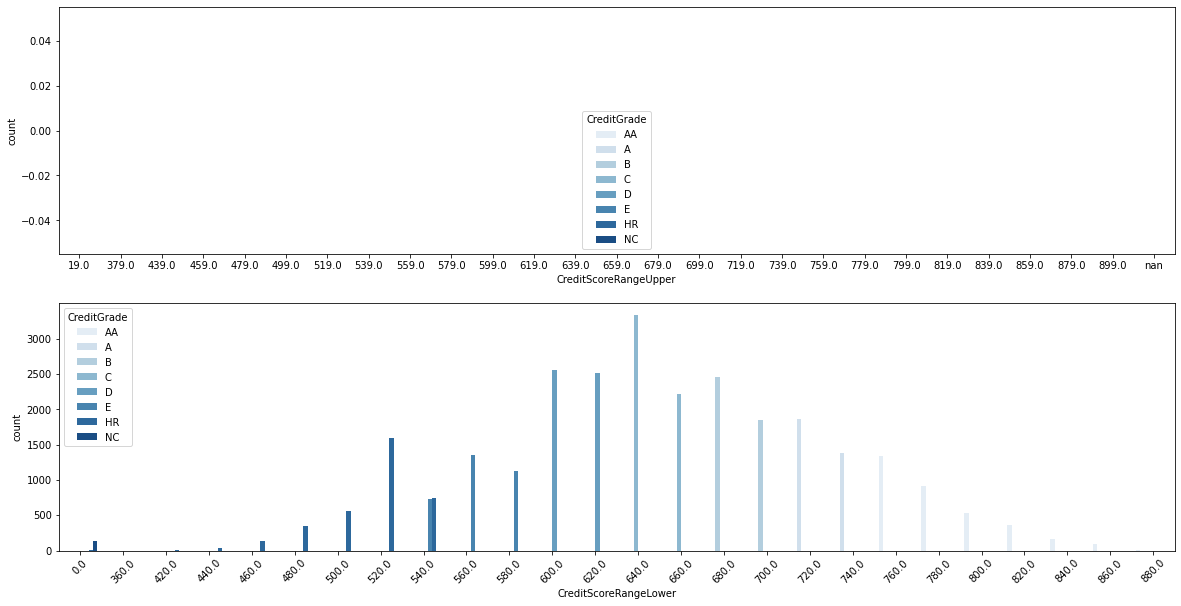

In [20]:
plt.figure(figsize = [20, 10])

# subplot 1: Credit Grade vs CSRU
plt.subplot(2, 1, 1)
sb.countplot(data = loans_to_2008, x = 'CreditScoreRangeUpper', hue = 'CreditGrade', palette = 'Blues')

# subplot 2: Credit Grade  vs CSRL
ax = plt.subplot(2, 1, 2)
sb.countplot(data = loans_to_2008, x = 'CreditScoreRangeLower', hue = 'CreditGrade', palette = 'Blues')
#ax.legend(ncol = 2) # re-arrange legend to reduce overlapping
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.figure(figsize = [8, 6])
plt.bar(data = loans_to_2008, x = 'CreditRange', y = 'StatedMonthlyIncome')
plt.xlabel('Credit Range (Upper)')
plt.ylabel('StatedMonthlyIncome')
plt.title('Credit Range VS SMI')
#plt.xlim(0,1000)

There's two more categories to compare against ROI:

nominal_vars = ('BorrowerState', 'Occupation')

binary_vars = ('IsBorrowerHomeowner', 'EmploymentStatus')

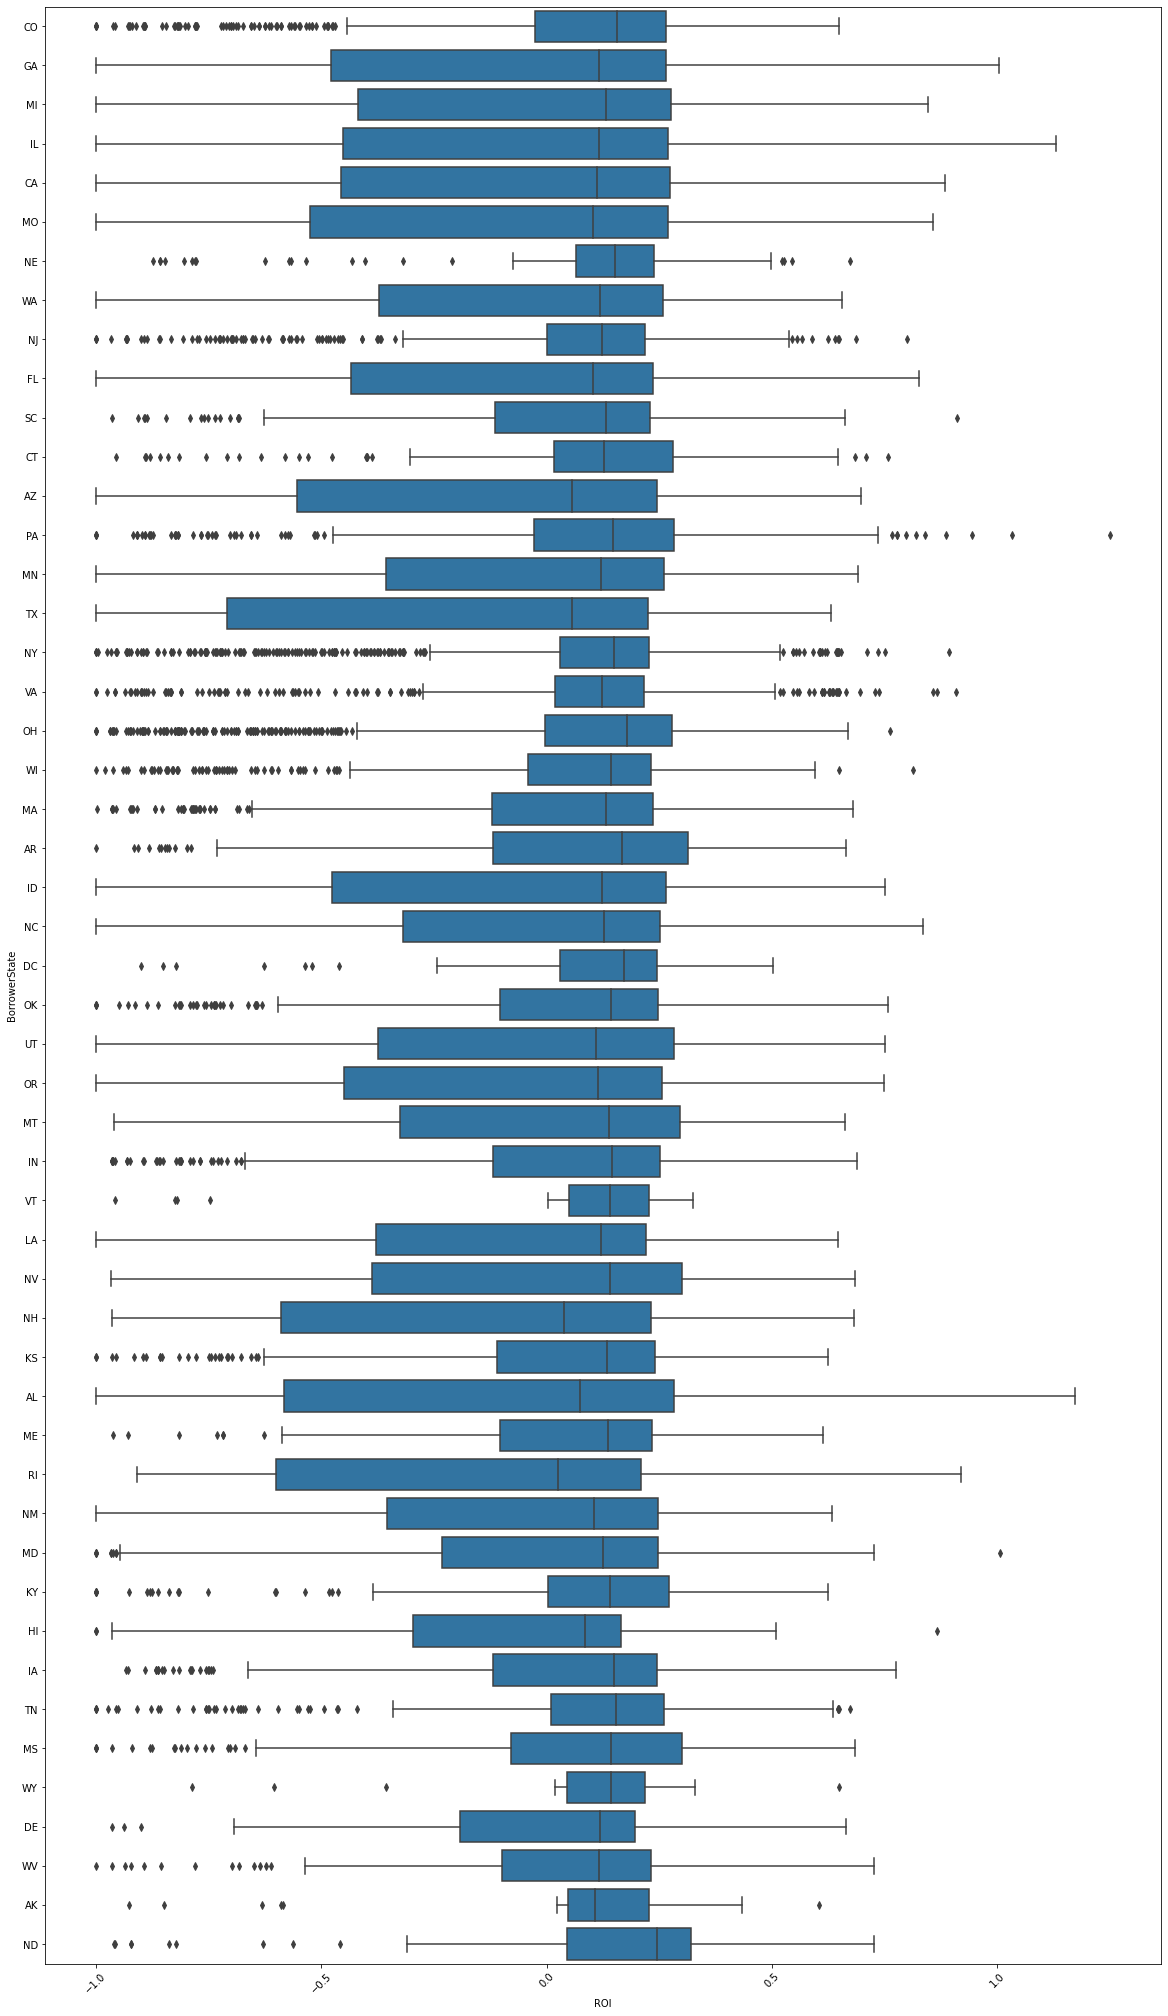

In [21]:
default_color = sb.color_palette()[0]
plt.figure(figsize = [20, 36])
g = sb.boxplot(data = loans_to_2008, x = 'ROI', y = 'BorrowerState', color=default_color)

plt.xticks(rotation=45)
plt.show();

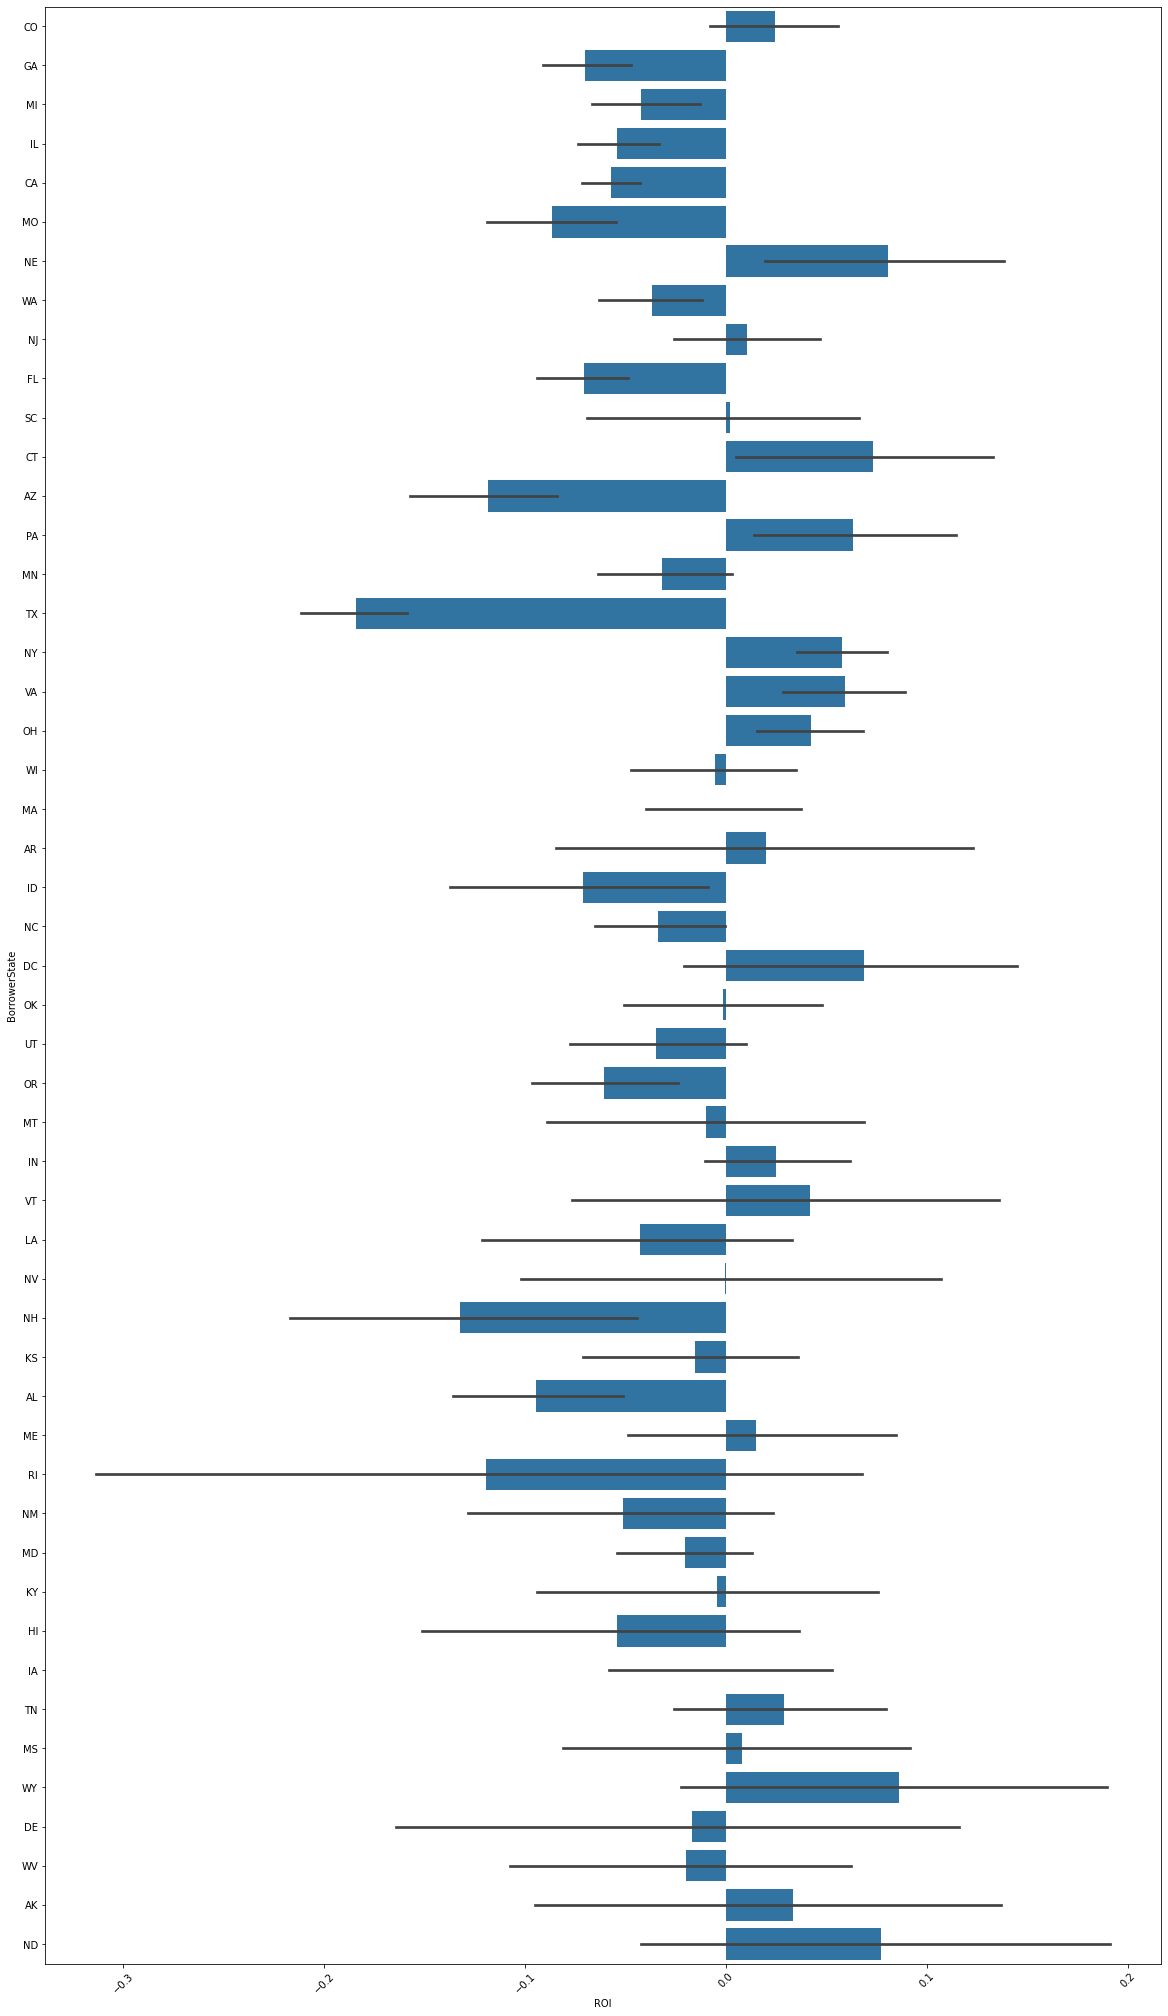

In [22]:
default_color = sb.color_palette()[0]
plt.figure(figsize = [20, 36])
g = sb.barplot(data = loans_to_2008, x = 'ROI', y = 'BorrowerState', color=default_color)

plt.xticks(rotation=45)
plt.show();

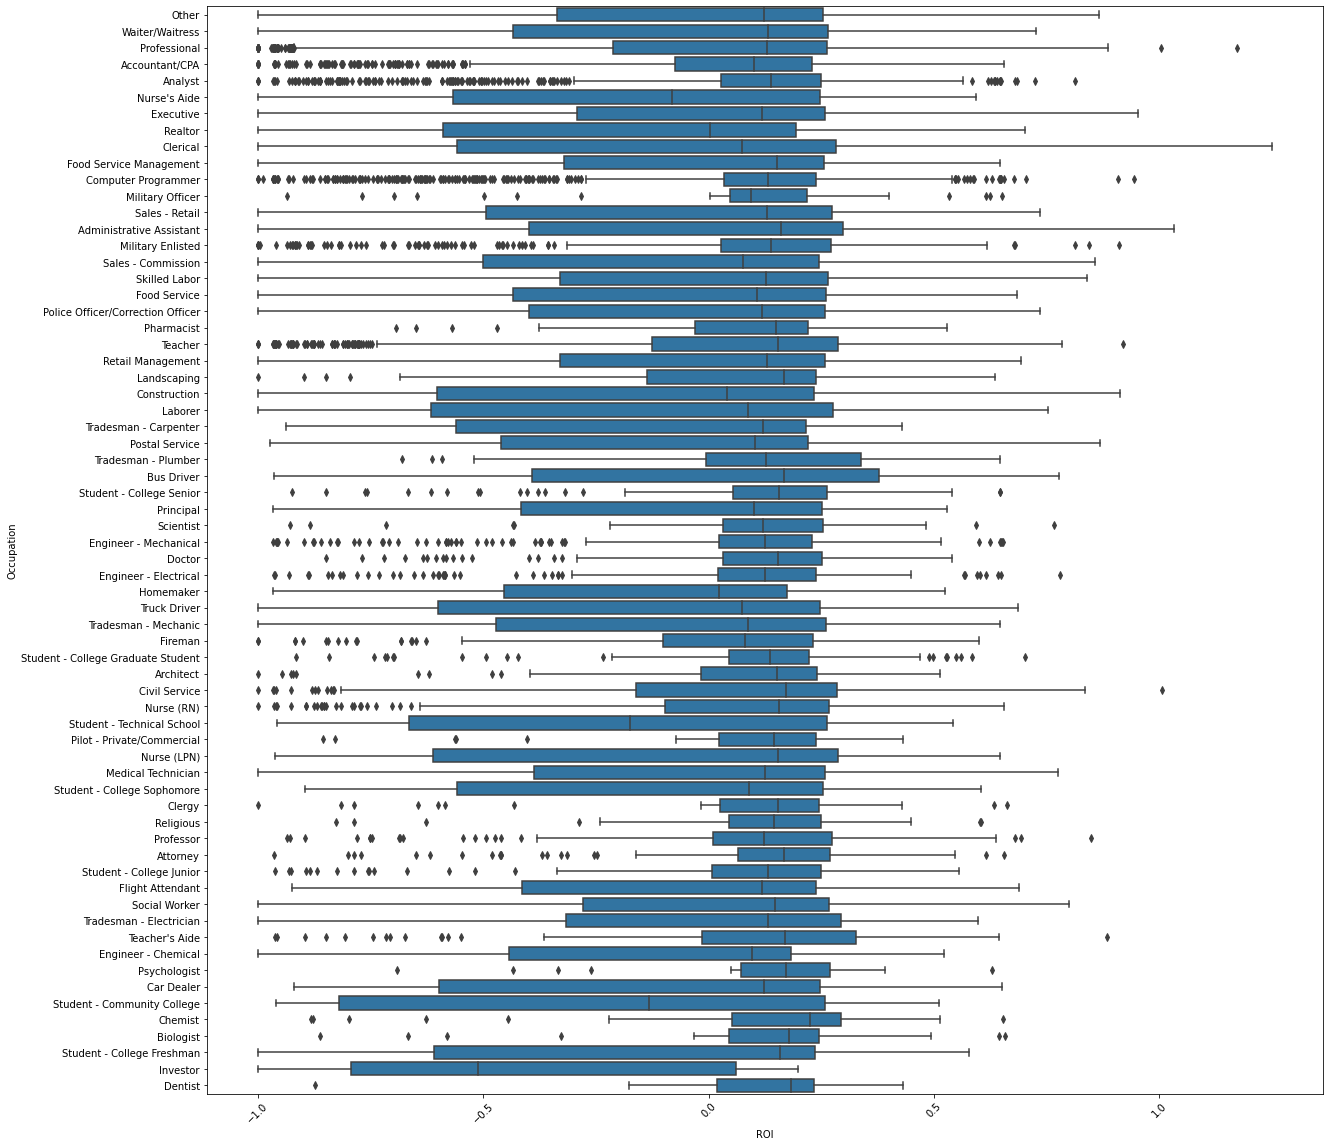

In [93]:
default_color = sb.color_palette()[0]
plt.figure(figsize = [20, 20])
g = sb.boxplot(data = loans_to_2008, x = 'ROI', y = 'Occupation', color=default_color)

plt.xticks(rotation=45)
plt.show();

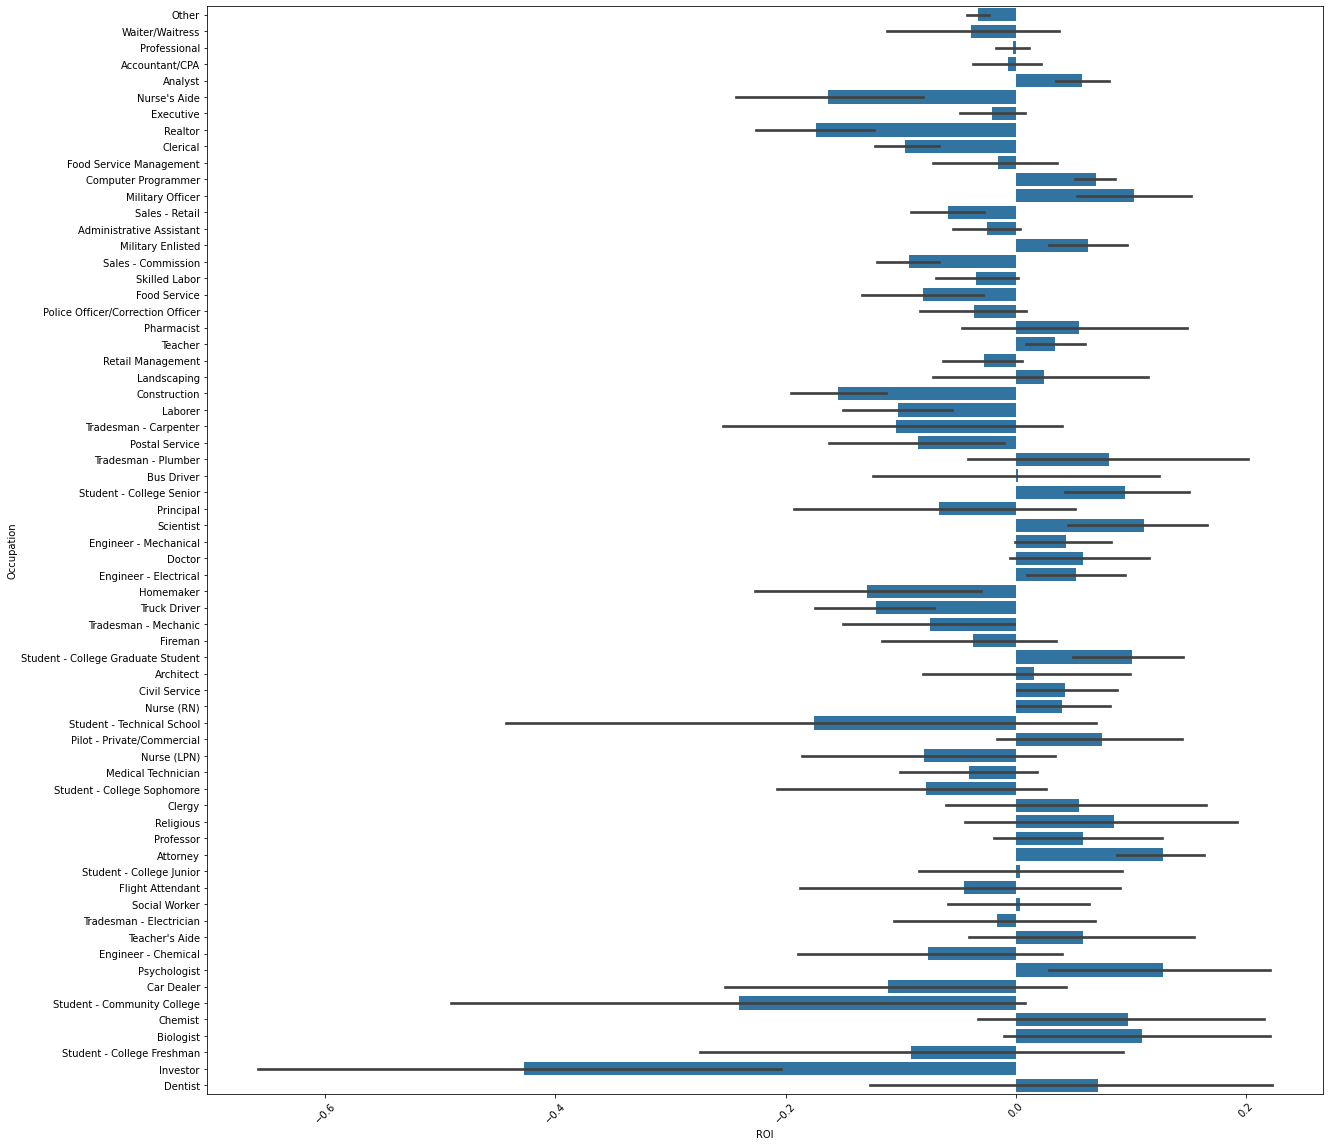

In [95]:
default_color = sb.color_palette()[0]
plt.figure(figsize = [20, 20])
g = sb.barplot(data = loans_to_2008, x = 'ROI', y = 'Occupation', color=default_color)

plt.xticks(rotation=45)
plt.show()

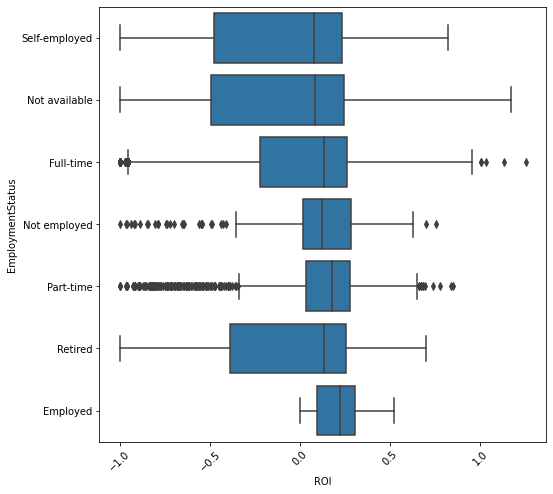

In [97]:
default_color = sb.color_palette()[0]
plt.figure(figsize = [8, 8])
g = sb.boxplot(data = loans_to_2008, x = 'ROI', y = 'EmploymentStatus', color=default_color)

plt.xticks(rotation=45)
plt.show();

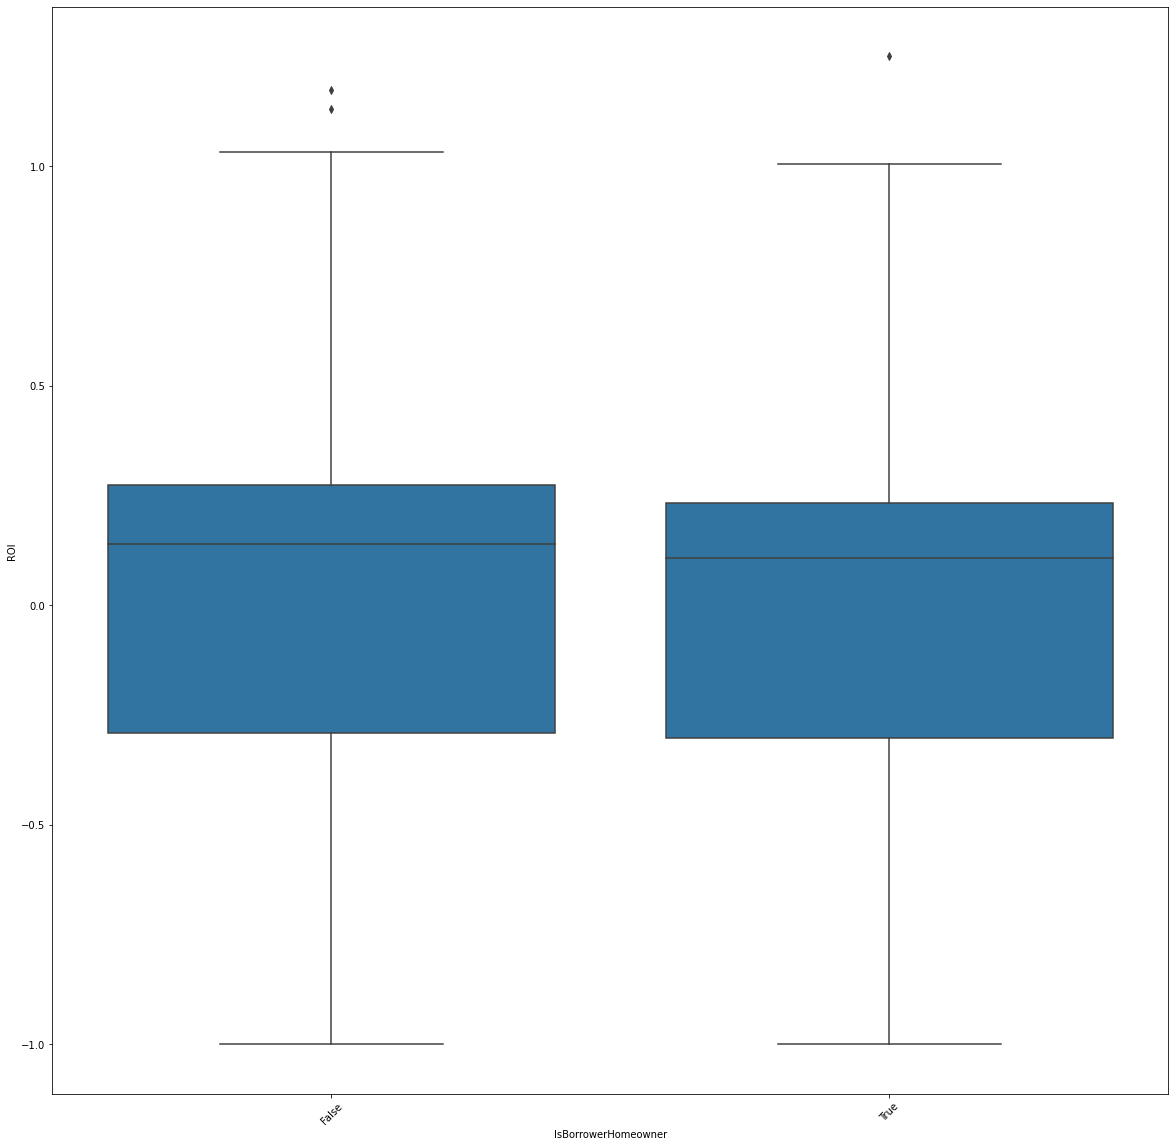

In [98]:
default_color = sb.color_palette()[0]
plt.figure(figsize = [20, 20])
g = sb.boxplot(data = loans_to_2008, x = 'IsBorrowerHomeowner', y = 'ROI', color=default_color)

plt.xticks(rotation=45)
plt.show();

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

This was disappointing. The StatedMonthlyIncome looked like it correlated fairly well to ROI, but the pearson score was very low (.02 for all the data; .03 when we zoomed in on the bulk of the data). Of the many variables describing the borrows that I examined, only CreditScore and CreditScoreRange seem to be good indicators of a loan's successful outcome. Unless the trends found in states or employment categories have some underlying justification and so would hold up as good predictors in the future (as opposed to just describing chance outcomes that won't necessarily repeat). And can Prosper reject applicants based on what state they live in? Is that allowed?

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

Stated Monthly Income and Income Ranges were closely related -- as you'd think they should be. There was also a discernible relationship between Credit Score and Income Ranges. So why was the Pearson score for ROI and Stated Monthly Income so low? Doesn't that imply that the correlation for Credit Range and ROI is also very low? But then how could Prosper meaningfully decide who to give loans to?

What if I compared Stated Monthly Income to the original Successful/Unsuccessful metric?

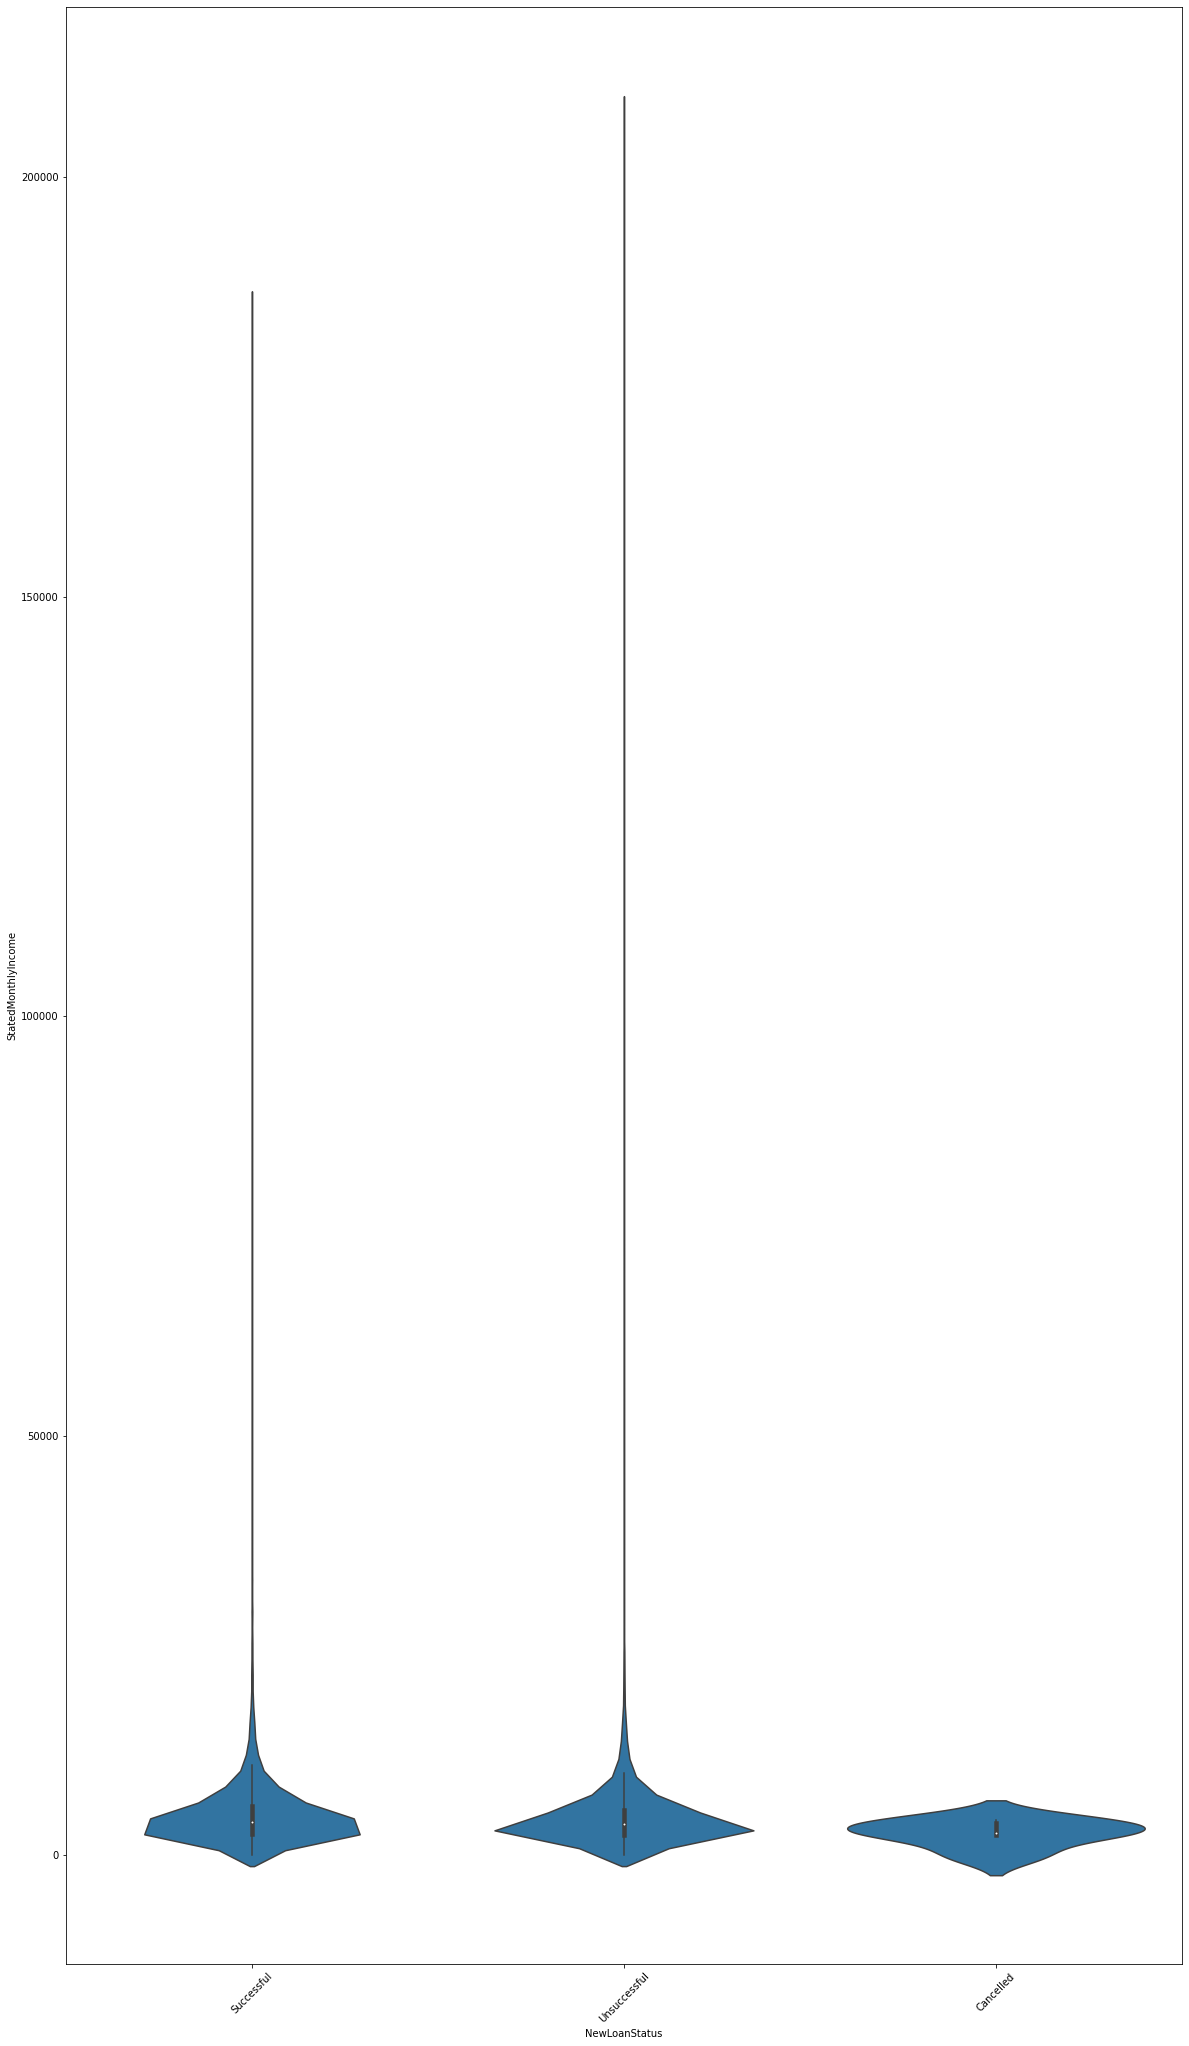

In [26]:
default_color = sb.color_palette()[0]
plt.figure(figsize = [20, 36])
g = sb.violinplot(data = loans_to_2008, y = 'StatedMonthlyIncome', x = 'NewLoanStatus', color=default_color)

plt.xticks(rotation=45)
plt.show();

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!